## Tạo đồ thị 

In [112]:
# build_social_graph.py
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

# ========= CẤU HÌNH =========
NODES_PATH = "nodes.csv"   # id,label
EDGES_PATH = "edges.csv"   # source,target,weight
DIRECTED = False           # False = đồ thị vô hướng; True = đồ thị hữu hướng
TOP_K = 20                 # số node nổi bật để gắn nhãn trong hình

# ========= ĐỌC DỮ LIỆU =========
nodes = pd.read_csv(NODES_PATH)
edges = pd.read_csv(EDGES_PATH)

# Kiểm tra cột cần thiết
assert set(["id", "label"]).issubset(nodes.columns), "nodes.csv cần cột: id,label"
assert set(["source", "target"]).issubset(edges.columns), "edges.csv cần cột: source,target"
if "weight" not in edges.columns:
    edges["weight"] = 1

# ========= TẠO ĐỒ THỊ =========
G = nx.DiGraph() if DIRECTED else nx.Graph()

# Thêm node với thuộc tính label
for _, r in nodes.iterrows():
    G.add_node(r["id"], label=r["label"])

# Thêm cạnh với trọng số
for _, r in edges.iterrows():
    G.add_edge(r["source"], r["target"], weight=float(r["weight"]))

# ========= TỔNG QUAN =========
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
if DIRECTED:
    comps = list(nx.weakly_connected_components(G))
else:
    comps = list(nx.connected_components(G))

largest_comp_nodes = max(comps, key=len) if len(comps) > 0 else set()
G_lcc = G.subgraph(largest_comp_nodes).copy()

print(f"Số node: {n_nodes}")
print(f"Số cạnh: {n_edges}")
print(f"Số thành phần liên thông: {len(comps)}")
print(f"Kích thước thành phần lớn nhất: {G_lcc.number_of_nodes()} nodes, {G_lcc.number_of_edges()} edges")

# ========= CHỈ SỐ TRUNG TÂM =========
# Độ (degree) và strength (tổng weight)
deg = dict(G.degree())
strength = {u: sum(d.get("weight", 1.0) for _, _, d in G.edges(u, data=True)) for u in G.nodes()}

# Betweenness (tương đối nặng; nếu to quá, có thể chạy trên LCC)
betw = nx.betweenness_centrality(G_lcc, weight="weight", normalized=True)
# Gán 0 cho các nút ngoài LCC
betw_full = {u: betw.get(u, 0.0) for u in G.nodes()}

# PageRank (chỉ thực sự hợp lý với đồ thị hữu hướng, nhưng cũng chạy được với vô hướng)
pr = nx.pagerank(G, weight="weight")

# Top K theo strength (ưu tiên trọng số)
top_strength = sorted(strength.items(), key=lambda x: x[1], reverse=True)[:TOP_K]
top_betw = sorted(betw_full.items(), key=lambda x: x[1], reverse=True)[:TOP_K]
top_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:TOP_K]

def pretty_top(lst, title):
    print("\n" + title)
    for i, (nid, val) in enumerate(lst, 1):
        print(f"{i:2d}. {G.nodes[nid].get('label', nid)} ({nid}) = {val:.4f}")

pretty_top(top_strength, "Top theo Strength (tổng trọng số cạnh)")
pretty_top(top_betw, "Top theo Betweenness (trên LCC)")
pretty_top(top_pr, "Top theo PageRank")

# ========= PHÁT HIỆN CỘNG ĐỒNG (vô hướng) =========
communities = None
if not DIRECTED:
    try:
        from networkx.algorithms.community import greedy_modularity_communities
        communities = list(greedy_modularity_communities(G_lcc, weight="weight"))
        print(f"\nSố cộng đồng (LCC): {len(communities)}")
        # Gán community id cho node trong LCC, ngoài LCC = -1
        comm_map = {}
        for cid, com in enumerate(communities):
            for u in com:
                comm_map[u] = cid
        nx.set_node_attributes(G, {u: comm_map.get(u, -1)}, "community")
    except Exception as e:
        print("Không chạy được detect cộng đồng (greedy modularity):", e)
else:
    nx.set_node_attributes(G, -1, "community")

# ========= VẼ ĐỒ THỊ =========
out_dir = Path("social_graph_output")
out_dir.mkdir(exist_ok=True)

# Layout trên LCC cho đỡ rối
pos = nx.spring_layout(G_lcc, weight="weight", k=None, seed=42)

# Kích thước node theo strength (rescale)
import numpy as np
strength_vals = np.array([strength[u] for u in G_lcc.nodes()])
if strength_vals.size == 0:
    strength_vals = np.array([1.0])
min_sz, max_sz = 100, 1500
s_min, s_max = strength_vals.min(), strength_vals.max()
if s_max > s_min:
    node_sizes = min_sz + (strength_vals - s_min) / (s_max - s_min) * (max_sz - min_sz)
else:
    node_sizes = np.full_like(strength_vals, (min_sz + max_sz) / 2.0)

# Vẽ không nhãn (toàn mạng LCC)
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_lcc, pos, node_size=node_sizes)
nx.draw_networkx_edges(G_lcc, pos, width=0.6, alpha=0.5)
plt.title("Mạng xã hội - Thành phần liên thông lớn nhất (không nhãn)")
plt.axis("off")
plt.tight_layout()
plt.savefig(out_dir / "graph_lcc_no_labels.png", dpi=300)
plt.close()

# Vẽ nhãn cho TOP_K theo strength
top_nodes = {nid for nid, _ in top_strength}
labels = {u: G.nodes[u].get("label", u) if u in top_nodes else "" for u in G_lcc.nodes()}
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_lcc, pos, node_size=node_sizes)
nx.draw_networkx_edges(G_lcc, pos, width=0.6, alpha=0.5)
nx.draw_networkx_labels(G_lcc, pos, labels=labels, font_size=8)
plt.title(f"Mạng xã hội - Gắn nhãn {TOP_K} nút nổi bật (theo Strength)")
plt.axis("off")
plt.tight_layout()
plt.savefig(out_dir / "graph_lcc_top_labels.png", dpi=300)
plt.close()

# ========= XUẤT FILE CHO GEPHI =========
# GEXF chứa thuộc tính label, community, và weight
nx.write_gexf(G, out_dir / "social_graph.gexf")
nx.write_graphml(G, out_dir / "social_graph.graphml")

# ========= XUẤT BẢNG CHỈ SỐ =========
rank_df = pd.DataFrame({
    "id": list(G.nodes())
})
rank_df["label"] = rank_df["id"].map(lambda x: G.nodes[x].get("label", x))
rank_df["degree"] = rank_df["id"].map(deg)
rank_df["strength"] = rank_df["id"].map(strength)
rank_df["betweenness_LCC"] = rank_df["id"].map(betw_full)
rank_df["pagerank"] = rank_df["id"].map(pr)
rank_df["community"] = rank_df["id"].map(lambda x: G.nodes[x].get("community", -1))

rank_df.sort_values(["strength", "degree", "pagerank"], ascending=False).to_csv(out_dir / "node_metrics.csv", index=False)

print("\nĐã lưu:")
print(f"- Ảnh: {out_dir/'graph_lcc_no_labels.png'}")
print(f"- Ảnh: {out_dir/'graph_lcc_top_labels.png'}")
print(f"- GEXF (mở bằng Gephi): {out_dir/'social_graph.gexf'}")
print(f"- GraphML: {out_dir/'social_graph.graphml'}")
print(f"- Bảng chỉ số: {out_dir/'node_metrics.csv'}")

Số node: 569
Số cạnh: 3405
Số thành phần liên thông: 13
Kích thước thành phần lớn nhất: 545 nodes, 3385 edges

Top theo Strength (tổng trọng số cạnh)
 1. NSƯT Hữu Châu (A000274) = 83.0000
 2. Tuấn Trần (A000493) = 66.0000
 3. NSND Hồng Vân (A000255) = 64.0000
 4. Quốc Cường (A000381) = 63.0000
 5. Quang Tuấn (A000373) = 60.0000
 6. Mạc Văn Khoa (A000249) = 52.0000
 7. Thu Trang (A000425) = 52.0000
 8. Kiều Minh Tuấn (A000177) = 51.0000
 9. Lê Giang (A000197) = 51.0000
10. Quách Ngọc Tuyên (A000378) = 47.0000
11. Kiều Trinh (A000179) = 46.0000
12. Hứa Vĩ Văn (A000143) = 45.0000
13. Khả Như (A000170) = 44.0000
14. Long Đẹp Trai (A000186) = 42.0000
15. Hồng Đào (A000141) = 41.0000
16. Quốc Khánh (A000383) = 40.0000
17. Tiến Luật (A000442) = 40.0000
18. Ngọc Tưởng (A000333) = 39.0000
19. Uyển Ân (A000506) = 38.0000
20. Hồng Ánh (A000139) = 37.0000

Top theo Betweenness (trên LCC)
 1. NSƯT Hữu Châu (A000274) = 0.1051
 2. Quốc Cường (A000381) = 0.0796
 3. Quang Tuấn (A000373) = 0.0624
 4. NS

In [113]:
# Chọn thành phần liên thông lớn nhất
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()
WORK_G = G_lcc  

print(f"LCC |V|={WORK_G.number_of_nodes()}, |E|={WORK_G.number_of_edges()}")

LCC |V|=545, |E|=3385


In [114]:
# Tách cạnh

import random
import networkx as nx

def split_edges_safe(G, test_ratio=0.2, seed=42, verbose=True):
    """
    Chia cạnh thành train/test theo tỉ lệ test_ratio, nhưng:
      - Chỉ chọn cạnh không phải bridge tại *thời điểm chọn* (recompute từng bước)
      - Đảm bảo sau khi bỏ test edges, G_train vẫn liên thông

    Trả về:
      G_train: đồ thị train (giữ nguyên node, bỏ test edges)
      train_edges: danh sách cạnh train
      test_edges: danh sách cạnh test (positive)
    """
    assert not G.is_directed(), "Hàm này thiết kế cho đồ thị vô hướng."
    random.seed(seed)

    # Làm việc trên bản copy để gỡ cạnh theo từng bước
    H = G.copy()
    m_total = H.number_of_edges()
    target_test = int(round(m_total * test_ratio))
    test_edges = []

    # Lặp đến khi đủ số cạnh test hoặc hết cạnh an toàn để chọn
    while len(test_edges) < target_test:
        # Tính bridges hiện tại; chỉ chọn cạnh không nằm trong bridges
        bridges = set(nx.bridges(H))
        candidates = [e for e in H.edges() if e not in bridges and (e[1], e[0]) not in bridges]
        if not candidates:
            if verbose:
                print(f"[B2] Không còn cạnh an toàn để chọn. Đã chọn được {len(test_edges)}/{target_test}.")
            break

        # Lấy ngẫu nhiên 1 cạnh an toàn và loại khỏi đồ thị tạm H
        e = random.choice(candidates)
        H.remove_edge(*e)
        test_edges.append(e)

    # Đồ thị train là H (sau khi đã bỏ test_edges)
    if not nx.is_connected(H):
        # Tránh trường hợp hiếm: loại dồn quá nhiều cạnh làm H tách nhỏ (do cắt nhiều cạnh cùng “bù đắp” nhau)
        # Nếu xảy ra, rollback về cách đơn giản hơn: chọn test_edges ít hơn để giữ liên thông.
        # Ở đây, ta thêm lại các test edge cho tới khi liên thông.
        for e in reversed(test_edges):
            if not nx.is_connected(H):
                H.add_edge(*e)          # thêm lại
            else:
                break
        # Cập nhật test_edges theo H hiện tại (tức là những cạnh còn bị loại)
        test_edges = [e for e in G.edges() if not H.has_edge(*e)]

    # Kết quả
    G_train = H
    train_edges = list(G_train.edges())

    if verbose:
        print(f"[B2] Tổng cạnh gốc: {m_total}")
        print(f"[B2] Test edges (positive): {len(test_edges)}")
        print(f"[B2] Train edges: {len(train_edges)}")
    return G_train, train_edges, test_edges


TEST_RATIO = 0.20 
G_train, train_edges, test_edges = split_edges_safe(WORK_G, test_ratio=TEST_RATIO, seed=42, verbose=True)

[B2] Tổng cạnh gốc: 3385
[B2] Test edges (positive): 677
[B2] Train edges: 2708


In [115]:
nx.is_connected(G_train)

True

## LCC

In [116]:
import networkx as nx
import random

# --- Bước 1: chọn thành phần liên thông lớn nhất ---
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()
WORK_G = G_lcc  

print(f"LCC |V|={WORK_G.number_of_nodes()}, |E|={WORK_G.number_of_edges()}")


# --- Bước 2: hàm tách cạnh an toàn (bridge-safe split) ---
def split_edges_safe(G, test_ratio=0.2, seed=42):
    random.seed(seed)
    edges = list(G.edges())
    num_test = int(len(edges) * test_ratio)
    test_edges, train_edges = [], []
    G_train = G.copy()

    # chọn cạnh bỏ vào test miễn không làm đứt graph
    attempts = 0
    while len(test_edges) < num_test and attempts < 10 * len(edges):
        e = random.choice(edges)
        if e not in test_edges:
            # kiểm tra bridge tại thời điểm này
            if not nx.has_path(G_train, e[0], e[1]):
                attempts += 1
                continue
            G_train.remove_edge(*e)
            if nx.is_connected(G_train):
                test_edges.append(e)
            else:
                G_train.add_edge(*e)  # rollback
        attempts += 1

    # phần còn lại là train_edges
    train_edges = [e for e in edges if e not in test_edges]
    return G_train, train_edges, test_edges


# --- Bước 3: chạy split cho Case 1 ---
G_train, train_edges, test_edges = split_edges_safe(WORK_G, test_ratio=0.2)

print(f"Train |V|={G_train.number_of_nodes()}, |E|={G_train.number_of_edges()}")
print(f"Test edges (positive only) = {len(test_edges)}")


LCC |V|=545, |E|=3385
Train |V|=545, |E|=2708
Test edges (positive only) = 677


In [117]:
# ==== CASE 1 — Heuristic evaluation (Group 1) ====
import numpy as np
import pandas as pd
import json
import random
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, auc
import os

# 1) Tạo negative test edges cân bằng (để tính ROC/PR)
#    (lấy ngẫu nhiên từ toàn bộ non-edges của G_train)
random.seed(42)
all_non_edges = list(nx.non_edges(G_train))
if len(all_non_edges) < len(test_edges):
    print(f"[WARN] Non-edges khả dụng ({len(all_non_edges)}) < số cần ({len(test_edges)}). Dùng tối đa có thể.")
neg_needed = min(len(test_edges), len(all_non_edges))
test_neg = random.sample(all_non_edges, neg_needed)

print(f"[Case 1] Positive test edges: {len(test_edges)}")
print(f"[Case 1] Negative test edges: {len(test_neg)} (sampled)")
print(f"[Case 1] Tổng mẫu test: {len(test_edges) + len(test_neg)}")

# 2) Heuristic scorers
class LocalSimilarityMethods:
    def __init__(self, G):
        self.G = G

    def common_neighbors(self, u, v):
        return len(set(self.G.neighbors(u)) & set(self.G.neighbors(v)))

    def jaccard(self, u, v):
        Nu, Nv = set(self.G.neighbors(u)), set(self.G.neighbors(v))
        inter, union = len(Nu & Nv), len(Nu | Nv)
        return inter / union if union > 0 else 0.0

    def adamic_adar(self, u, v):
        Nu, Nv = set(self.G.neighbors(u)), set(self.G.neighbors(v))
        s = 0.0
        for w in (Nu & Nv):
            deg = self.G.degree(w)
            if deg > 1:
                s += 1.0 / np.log(deg)
        return s

    def preferential_attachment(self, u, v):
        return self.G.degree(u) * self.G.degree(v)

    def resource_allocation(self, u, v):
        Nu, Nv = set(self.G.neighbors(u)), set(self.G.neighbors(v))
        s = 0.0
        for w in (Nu & Nv):
            deg = self.G.degree(w)
            if deg > 0:
                s += 1.0 / deg
        return s

    def calc_for_edges(self, edge_list):
        rows = []
        for u, v in edge_list:
            rows.append({
                "u": u, "v": v,
                "common_neighbors": self.common_neighbors(u, v),
                "jaccard": self.jaccard(u, v),
                "adamic_adar": self.adamic_adar(u, v),
                "preferential_attachment": self.preferential_attachment(u, v),
                "resource_allocation": self.resource_allocation(u, v),
            })
        return pd.DataFrame(rows)

# 3) Tính điểm cho pos/neg
sim = LocalSimilarityMethods(G_train)
df_pos = sim.calc_for_edges(test_edges); df_pos["label"] = 1
df_neg = sim.calc_for_edges(test_neg);   df_neg["label"] = 0
test_data = pd.concat([df_pos, df_neg], ignore_index=True)

# 4) Đánh giá và lưu result_1.csv
heuristic_cols = [
    "common_neighbors",
    "jaccard",
    "adamic_adar",
    "preferential_attachment",
    "resource_allocation",
]

rows = []
y_true = test_data["label"].values
for col in heuristic_cols:
    y_score = test_data[col].values
    mask = ~(np.isnan(y_score) | np.isinf(y_score))
    y_true_c, y_score_c = y_true[mask], y_score[mask]
    if y_true_c.size == 0:
        continue

    fpr, tpr, _ = roc_curve(y_true_c, y_score_c)
    auc_roc = roc_auc_score(y_true_c, y_score_c)
    precision, recall, _ = precision_recall_curve(y_true_c, y_score_c)
    auc_pr = auc(recall, precision)
    ap = average_precision_score(y_true_c, y_score_c)

    rows.append({
        "model": col,
        "AUC_ROC": auc_roc,
        "AUC_PR": auc_pr,
        "Average_Precision": ap,
        "fpr": json.dumps(fpr.tolist()),
        "tpr": json.dumps(tpr.tolist()),
        "precision": json.dumps(precision.tolist()),
        "recall": json.dumps(recall.tolist())
    })

eval_df_case1 = pd.DataFrame(rows).sort_values("AUC_ROC", ascending=False)
print("Kết quả heuristic — CASE 1:")
print(eval_df_case1.round(4))

out_file = "result_1.csv"
if os.path.exists(out_file):
    eval_df_case1.to_csv(out_file, mode="a", header=False, index=False)
else:
    eval_df_case1.to_csv(out_file, index=False)
print(f"Đã ghi kết quả CASE 1 (heuristics) vào {out_file}")

# 5) Lưu per-edge scores (để vẽ phân phối điểm)
long_rows = []
for col in heuristic_cols:
    tmp = test_data[["u", "v", "label"]].copy()
    tmp["score"] = test_data[col].values
    tmp["model"] = col
    tmp["case"] = "case1"
    tmp["group"] = "Heuristic"
    long_rows.append(tmp)

scores_case1_group1 = pd.concat(long_rows, ignore_index=True)
scores_case1_group1.to_csv("scores_case1_group1.csv", index=False)
print("Đã lưu per-edge scores Nhóm 1 (Case 1) vào scores_case1_group1.csv")

[Case 1] Positive test edges: 677
[Case 1] Negative test edges: 677 (sampled)
[Case 1] Tổng mẫu test: 1354
Kết quả heuristic — CASE 1:
                     model  AUC_ROC  AUC_PR  Average_Precision  \
2              adamic_adar   0.9909  0.9901             0.9892   
4      resource_allocation   0.9901  0.9871             0.9862   
0         common_neighbors   0.9887  0.9887             0.9837   
1                  jaccard   0.9868  0.9840             0.9827   
3  preferential_attachment   0.7392  0.7522             0.7512   

                                                 fpr  \
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00147710...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.001477104874446085...   

                                                 tpr  \
2  [0.0, 0.0014771048744460858, 0.090103397341211...   
4  [0.0, 0.00147710

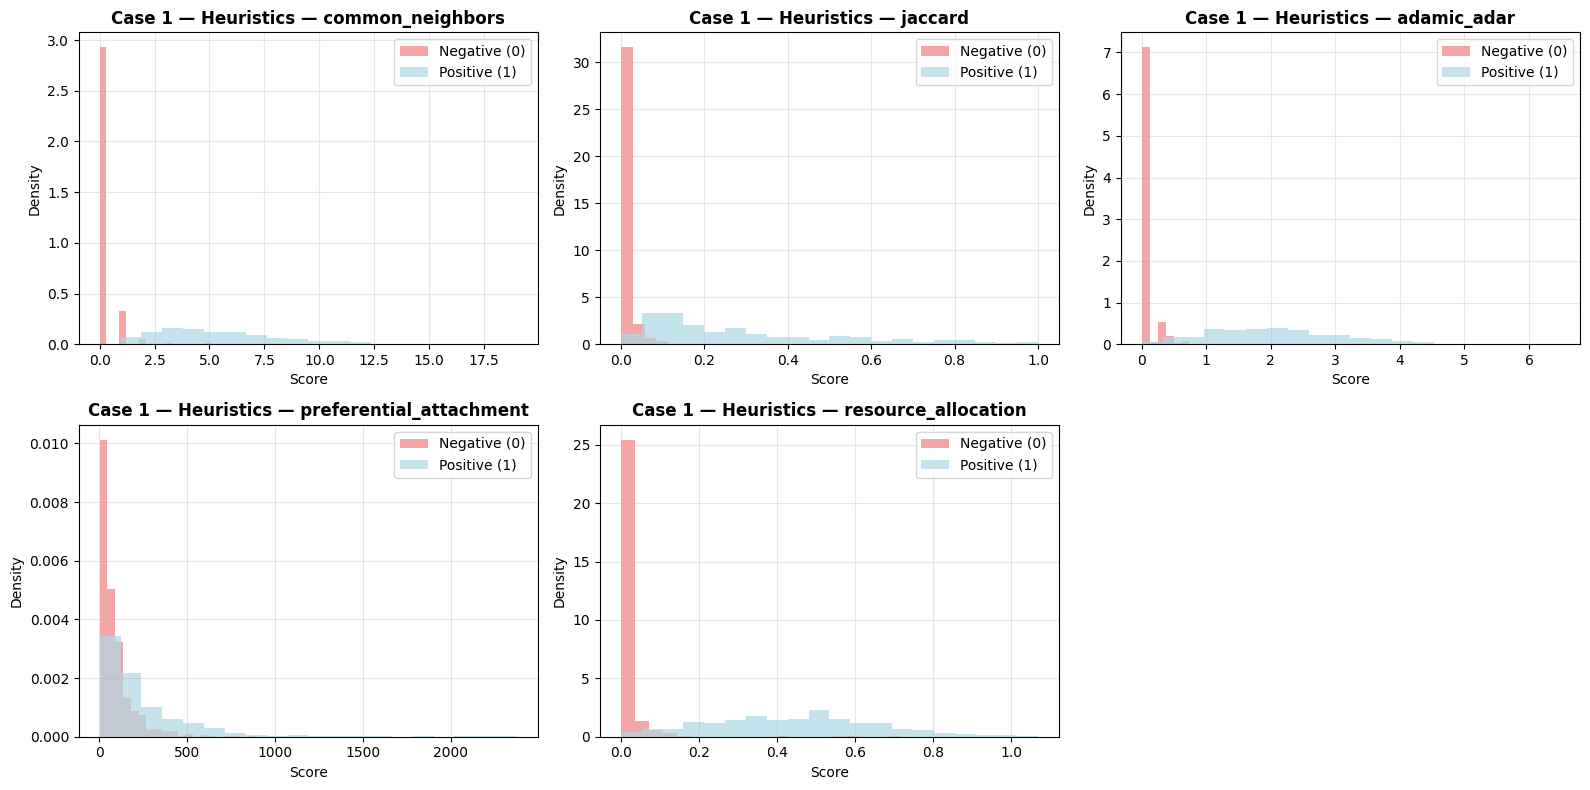

In [118]:
# ==== PHÂN PHỐI ĐIỂM — NHÓM 1 (CASE 1) ====
import numpy as np
import matplotlib.pyplot as plt

def plot_score_distribution_by_model(df, title_prefix="Case 1 — Heuristics"):
    models = df["model"].unique().tolist()
    n = len(models)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4*nrows))

    # ép axes về list Axes để không lỗi khi n==1
    if isinstance(axes, np.ndarray):
        axes = axes.flatten().tolist()
    else:
        axes = [axes]

    for i, m in enumerate(models):
        sub = df[df["model"] == m]
        pos = sub[sub["label"] == 1]["score"]
        neg = sub[sub["label"] == 0]["score"]

        ax = axes[i]
        ax.hist(neg, bins=20, alpha=0.7, density=True,
                color="lightcoral", label="Negative (0)")
        ax.hist(pos, bins=20, alpha=0.7, density=True,
                color="lightblue", label="Positive (1)")
        ax.set_title(f"{title_prefix} — {m}", fontweight='bold')
        ax.set_xlabel("Score")
        ax.set_ylabel("Density")
        ax.grid(True, alpha=0.3)
        ax.legend()

    # Ẩn subplot thừa
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Vẽ từ DataFrame vừa tạo (hoặc đọc lại từ CSV nếu muốn)
plot_score_distribution_by_model(scores_case1_group1)

## MÔ HÌNH HỌC MÁY DỰ ĐOÁN LIÊN KẾT (EDGE CLASSIFICATION) VỚI ĐẶC TRƯNG THỦ CÔNG


In [119]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import os, json

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, auc, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# ===== Kiểm tra các biến đầu vào =====
for var in ["G_train", "train_edges", "test_edges"]:
    if var not in globals():
        raise RuntimeError(f"Thiếu biến {var}. Hãy chạy B2–B3 trước.")
if "test_neg" not in globals():
    if "test_negative" in globals():
        test_neg = test_negative
    else:
        raise RuntimeError("Thiếu negative test edges. Gán vào biến 'test_neg' trước.")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ===== (B5.1) HÀM TẠO ĐẶC TRƯNG =====
def pair_features(G, u, v):
    Nu, Nv = set(G.neighbors(u)), set(G.neighbors(v))
    inter, union = Nu & Nv, Nu | Nv

    du, dv = G.degree(u), G.degree(v)
    cn = len(inter)
    jacc = (len(inter) / len(union)) if len(union) > 0 else 0.0

    aa = sum(1.0 / np.log(G.degree(w)) for w in inter if G.degree(w) > 1)
    ra = sum(1.0 / G.degree(w) for w in inter if G.degree(w) > 0)
    pa = du * dv

    try:
        spl = nx.shortest_path_length(G, u, v)
    except nx.NetworkXNoPath:
        spl = 1e6

    return {
        "deg_u": du, "deg_v": dv,
        "deg_sum": du + dv,
        "deg_prod": du * dv,
        "deg_min": min(du, dv),
        "deg_max": max(du, dv),
        "common_neighbors": cn,
        "jaccard": jacc,
        "adamic_adar": aa,
        "resource_allocation": ra,
        "preferential_attachment": pa,
        "shortest_path_len": spl,
    }

def build_feature_df(G, edge_list, label):
    rows = []
    for (u, v) in edge_list:
        fv = pair_features(G, u, v)
        fv["u"], fv["v"], fv["label"] = u, v, label
        rows.append(fv)
    return pd.DataFrame(rows)

# ===== (B5.2) TẠO TẬP TRAIN =====
pos_train = list(train_edges)

def sample_negatives(G, num_samples, seed=SEED):
    rng = random.Random(seed)
    negs, nodes = set(), list(G.nodes())
    while len(negs) < num_samples:
        u, v = rng.choice(nodes), rng.choice(nodes)
        if u == v: continue
        a, b = (u, v) if u < v else (v, u)
        if G.has_edge(a, b): continue
        if (a, b) in negs: continue
        negs.add((a, b))
    return list(negs)

neg_train = sample_negatives(G_train, len(pos_train), seed=SEED)

train_pos_df = build_feature_df(G_train, pos_train, 1)
train_neg_df = build_feature_df(G_train, neg_train, 0)
train_df = pd.concat([train_pos_df, train_neg_df], ignore_index=True)

print(f"[B5] Train set: pos={len(train_pos_df)}, neg={len(train_neg_df)}, total={len(train_df)}")

# ===== (B5.3) TẠO TẬP TEST =====
test_pos_df = build_feature_df(G_train, test_edges, 1)
test_neg_df = build_feature_df(G_train, test_neg, 0)
test_df_ml = pd.concat([test_pos_df, test_neg_df], ignore_index=True)

print(f"[B5] Test set: pos={len(test_pos_df)}, neg={len(test_neg_df)}, total={len(test_df_ml)}")

# ===== (B5.4) HUẤN LUYỆN & ĐÁNH GIÁ =====
feature_cols = [
    "deg_u","deg_v","deg_sum","deg_prod","deg_min","deg_max",
    "common_neighbors","jaccard","adamic_adar","resource_allocation",
    "preferential_attachment","shortest_path_len"
]

X_train, y_train = train_df[feature_cols].values, train_df["label"].values
X_test,  y_test  = test_df_ml[feature_cols].values, test_df_ml["label"].values

models = {
    "LR(handcrafted)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=SEED))
    ]),
    "RF(handcrafted)": RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=SEED, n_jobs=-1
    ),
    "GBDT(handcrafted)": GradientBoostingClassifier(random_state=SEED)
}

def eval_model(clf, X_tr, y_tr, X_te, y_te, name):
    clf.fit(X_tr, y_tr)
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_te)[:, 1]
    else:
        y_score = clf.decision_function(X_te)

    fpr, tpr, _ = roc_curve(y_te, y_score)
    auc_roc = roc_auc_score(y_te, y_score)

    precision, recall, _ = precision_recall_curve(y_te, y_score)
    auc_pr = auc(recall, precision)
    ap = average_precision_score(y_te, y_score)

    return {
        "model": name,
        "AUC_ROC": auc_roc,
        "AUC_PR": auc_pr,
        "Average_Precision": ap,
        "fpr": json.dumps(fpr.tolist()),
        "tpr": json.dumps(tpr.tolist()),
        "precision": json.dumps(precision.tolist()),
        "recall": json.dumps(recall.tolist())
    }

eval_rows = []
for name, clf in models.items():
    res = eval_model(clf, X_train, y_train, X_test, y_test, name)
    eval_rows.append(res)
    print(f"[{name}] AUC-ROC={res['AUC_ROC']:.4f} | AUC-PR={res['AUC_PR']:.4f} | AP={res['Average_Precision']:.4f}")

eval_ml_df = pd.DataFrame(eval_rows)

# ===== (B5.5) GHI KẾT QUẢ VÀO result_1.csv =====
out_file = "result_1.csv"
if os.path.exists(out_file):
    eval_ml_df.to_csv(out_file, mode="a", header=False, index=False)
else:
    eval_ml_df.to_csv(out_file, index=False)

print(f"Đã append kết quả nhóm 2 vào {out_file}")
print(eval_ml_df.sort_values('AUC_ROC', ascending=False))

[B5] Train set: pos=2708, neg=2708, total=5416
[B5] Test set: pos=677, neg=677, total=1354
[LR(handcrafted)] AUC-ROC=0.9919 | AUC-PR=0.9883 | AP=0.9883
[RF(handcrafted)] AUC-ROC=0.9885 | AUC-PR=0.9861 | AP=0.9850
[GBDT(handcrafted)] AUC-ROC=0.5000 | AUC-PR=0.7500 | AP=0.5000
Đã append kết quả nhóm 2 vào result_1.csv
               model   AUC_ROC    AUC_PR  Average_Precision  \
0    LR(handcrafted)  0.991875  0.988310           0.988324   
1    RF(handcrafted)  0.988459  0.986096           0.984982   
2  GBDT(handcrafted)  0.500000  0.750000           0.500000   

                                                 fpr  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...   
2                                         [0.0, 1.0]   

                                                 tpr  \
0  [0.0, 0.0014771048744460858, 0.097488921713441...   
1  [0.0, 0.004431314623338257, 0.0073855243722304...   
2                                   

In [120]:
# ==== LƯU PER-EDGE SCORES — NHÓM 2 (CASE 1) ====
all_scores_rows = []
for name, clf in models.items():
    # train lại đúng pipeline đã dùng để tính điểm test
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

    tmp = test_df_ml[["u", "v", "label"]].copy()
    tmp["score"] = y_score
    tmp["model"] = name
    tmp["group"] = "ML(handcrafted)"
    tmp["case"]  = "case1"
    all_scores_rows.append(tmp)

scores_case1_group2 = pd.concat(all_scores_rows, ignore_index=True)
scores_out = "scores_case1_group2.csv"
if os.path.exists(scores_out):
    scores_case1_group2.to_csv(scores_out, mode="a", header=False, index=False)
else:
    scores_case1_group2.to_csv(scores_out, index=False)

print(f"Đã lưu per-edge scores Nhóm 2 (Case 1) vào {scores_out}")
print(scores_case1_group2.groupby("model")["score"].describe()[["mean","std","min","max"]])

Đã lưu per-edge scores Nhóm 2 (Case 1) vào scores_case1_group2.csv
                       mean           std           min       max
model                                                            
GBDT(handcrafted)  0.000022  3.389384e-21  2.190173e-05  0.000022
LR(handcrafted)    0.220644  2.967667e-01  2.671587e-17  0.991984
RF(handcrafted)    0.083626  8.570259e-02  0.000000e+00  0.226667


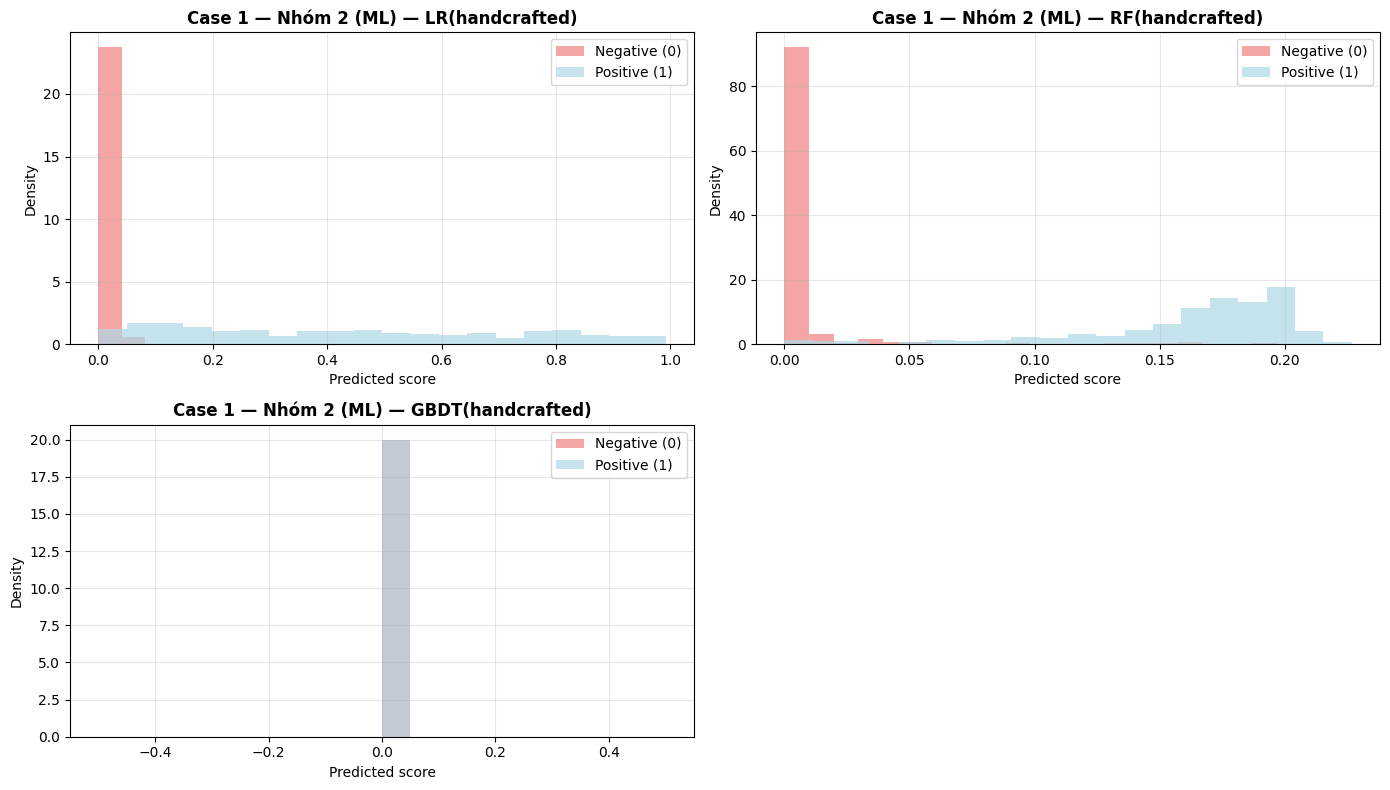

In [121]:
# ==== PHÂN PHỐI ĐIỂM — NHÓM 2 (CASE 1) ====
import numpy as np
import matplotlib.pyplot as plt

def plot_score_distribution_by_model(df, title_prefix="Case 1 — Nhóm 2 (ML)"):
    models = df["model"].unique().tolist()
    n = len(models)
    ncols = 2
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))

    # luôn ép về list Axes để tránh lỗi khi n==1
    if isinstance(axes, np.ndarray):
        axes = axes.flatten().tolist()
    else:
        axes = [axes]

    for i, m in enumerate(models):
        sub = df[df["model"] == m]
        pos = sub.loc[sub["label"] == 1, "score"]
        neg = sub.loc[sub["label"] == 0, "score"]

        ax = axes[i]
        ax.hist(neg, bins=20, alpha=0.7, density=True, color="lightcoral", label="Negative (0)")
        ax.hist(pos, bins=20, alpha=0.7, density=True, color="lightblue",  label="Positive (1)")

        ax.set_title(f"{title_prefix} — {m}", fontweight='bold')
        ax.set_xlabel("Predicted score"); ax.set_ylabel("Density")
        ax.grid(True, alpha=0.3); ax.legend()

    # Ẩn subplot thừa nếu có
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(); plt.show()

# Vẽ trực tiếp từ DataFrame vừa tạo (hoặc đọc lại từ CSV nếu muốn)
plot_score_distribution_by_model(scores_case1_group2)

## Embeding

In [122]:
# ===== NHÓM 3: Node2Vec Embedding + Logistic Regression (Hadamard) =====
import numpy as np
import pandas as pd
import networkx as nx
import os, json

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, auc, roc_curve
)

SEED = 42

# ---- 0) Kiểm tra biến có sẵn từ các bước trước ----
need_vars = ["G_train", "train_edges", "test_edges"]
for v in need_vars:
    if v not in globals():
        raise RuntimeError(f"Thiếu biến {v}. Hãy chạy các bước trước (B2–B3–B5).")

if "test_neg" not in globals():
    if "test_negative" in globals():
        test_neg = test_negative
    else:
        raise RuntimeError("Thiếu negative test edges (test_neg).")

# cũng tận dụng neg_train/pos_train nếu đã tạo ở B5; nếu chưa thì tạo ở đây
if "pos_train" not in globals():
    pos_train = list(train_edges)

if "neg_train" not in globals():
    import random
    def sample_negatives(G, num_samples, seed=SEED):
        rng = random.Random(seed)
        negs = set()
        nodes = list(G.nodes())
        while len(negs) < num_samples:
            u, v = rng.choice(nodes), rng.choice(nodes)
            if u == v: continue
            a, b = (u, v) if u < v else (v, u)
            if G.has_edge(a, b): continue
            if (a, b) in negs: continue
            negs.add((a, b))
        return list(negs)
    neg_train = sample_negatives(G_train, len(pos_train), seed=SEED)

# ---- 1) Lấy embedding cho node từ G_train ----
EMBED_DIM = 128

def learn_embeddings(G, dim=EMBED_DIM, seed=SEED):
    nodes = list(G.nodes())
    node_index = {n: i for i, n in enumerate(nodes)}
    emb, method_name = None, None

    try:
        from node2vec import Node2Vec
        n2v = Node2Vec(
            G, dimensions=dim, walk_length=80, num_walks=10,
            p=1, q=1, seed=seed, workers=1, quiet=True
        )
        w2v = n2v.fit(window=10, min_count=1, batch_words=128, seed=seed)
        emb = np.zeros((len(nodes), dim), dtype=float)
        for n in nodes:
            try:
                emb[node_index[n]] = w2v.wv[str(n)]
            except KeyError:
                emb[node_index[n]] = np.random.RandomState(seed).normal(0, 0.01, size=dim)
        method_name = "Node2Vec"
    except Exception:
        from scipy import sparse
        from sklearn.decomposition import TruncatedSVD
        A = nx.to_scipy_sparse_matrix(G, nodelist=nodes, dtype=float, format="csr")
        deg = np.asarray(A.sum(axis=1)).ravel()
        deg[deg == 0] = 1.0
        Dinv = sparse.diags(1.0 / deg)
        P = Dinv @ A
        svd = TruncatedSVD(n_components=dim, random_state=seed)
        emb = svd.fit_transform(P)
        method_name = "AdjSVD"
        print("[Nhóm 3] Không tìm thấy node2vec → fallback TruncatedSVD.")

    return nodes, node_index, emb, method_name

nodes_order, node_idx, node_emb, embed_backend = learn_embeddings(G_train, dim=EMBED_DIM, seed=SEED)
print(f"[Nhóm 3] Embedding backend: {embed_backend}, dim={node_emb.shape[1]}")

# ---- 2) Hàm tạo edge-embedding bằng Hadamard ----
def edge_hadamard(u, v):
    iu, iv = node_idx[u], node_idx[v]
    return node_emb[iu] * node_emb[iv]

def make_edge_matrix(edge_list):
    return np.vstack([edge_hadamard(u, v) for (u, v) in edge_list])

# ---- 3) Tạo tập train/test ----
X_tr_pos = make_edge_matrix(pos_train)
X_tr_neg = make_edge_matrix(neg_train)
X_train = np.vstack([X_tr_pos, X_tr_neg])
y_train = np.hstack([np.ones(len(X_tr_pos)), np.zeros(len(X_tr_neg))])

X_te_pos = make_edge_matrix(test_edges)
X_te_neg = make_edge_matrix(test_neg)
X_test = np.vstack([X_te_pos, X_te_neg])
y_test = np.hstack([np.ones(len(X_te_pos)), np.zeros(len(X_te_neg))])

# ---- 4) Huấn luyện + đánh giá ----
clf = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=2000, random_state=SEED))
])
clf.fit(X_train, y_train)

if hasattr(clf, "predict_proba"):
    y_score = clf.predict_proba(X_test)[:, 1]
else:
    y_score = clf.decision_function(X_test)

# Metrics + đường cong
fpr, tpr, _ = roc_curve(y_test, y_score)
auc_roc = roc_auc_score(y_test, y_score)

prec, rec, _ = precision_recall_curve(y_test, y_score)
auc_pr = auc(rec, prec)
ap = average_precision_score(y_test, y_score)

model_name = f"{embed_backend}+LR(Hadamard)"
print(f"[{model_name}] AUC-ROC={auc_roc:.4f} | AUC-PR={auc_pr:.4f} | AP={ap:.4f}")

# ---- 5) Ghi kết quả vào result_1.csv ----
row = pd.DataFrame([{
    "model": model_name,
    "AUC_ROC": auc_roc,
    "AUC_PR": auc_pr,
    "Average_Precision": ap,
    "fpr": json.dumps(fpr.tolist()),
    "tpr": json.dumps(tpr.tolist()),
    "precision": json.dumps(prec.tolist()),
    "recall": json.dumps(rec.tolist())
}])

out_file = "result_1.csv"
if os.path.exists(out_file):
    row.to_csv(out_file, mode="a", header=False, index=False)
else:
    row.to_csv(out_file, index=False)

print(f"Đã append kết quả Nhóm 3 vào {out_file}")

[Nhóm 3] Embedding backend: Node2Vec, dim=128
[Node2Vec+LR(Hadamard)] AUC-ROC=0.9362 | AUC-PR=0.9318 | AP=0.9318
Đã append kết quả Nhóm 3 vào result_1.csv


In [123]:
# ==== LƯU PER-EDGE SCORES — NHÓM 3 (CASE 1) ====
scores_case1_group3 = pd.DataFrame({
    "u": [u for (u, v) in list(test_edges) + list(test_neg)],
    "v": [v for (u, v) in list(test_edges) + list(test_neg)],
    "label": np.hstack([np.ones(len(test_edges), dtype=int),
                        np.zeros(len(test_neg), dtype=int)]),
    "score": y_score,
})
scores_case1_group3["model"] = model_name           # ví dụ: "Node2Vec+LR(Hadamard)" hoặc "AdjSVD+LR(Hadamard)"
scores_case1_group3["group"] = "Embedding"
scores_case1_group3["case"]  = "case1"

scores_out = "scores_case1_group3.csv"
if os.path.exists(scores_out):
    scores_case1_group3.to_csv(scores_out, mode="a", header=False, index=False)
else:
    scores_case1_group3.to_csv(scores_out, index=False)

print(f"Đã lưu per-edge scores Nhóm 3 (Case 1) vào {scores_out}")
print(scores_case1_group3.head())

Đã lưu per-edge scores Nhóm 3 (Case 1) vào scores_case1_group3.csv
         u        v  label     score                  model      group   case
0  A000305  A000370      1  0.359706  Node2Vec+LR(Hadamard)  Embedding  case1
1  A000048  A000125      1  0.706480  Node2Vec+LR(Hadamard)  Embedding  case1
2  A000010  A000550      1  0.494366  Node2Vec+LR(Hadamard)  Embedding  case1
3  A000386  A000516      1  0.990654  Node2Vec+LR(Hadamard)  Embedding  case1
4  A000121  A000191      1  0.950597  Node2Vec+LR(Hadamard)  Embedding  case1


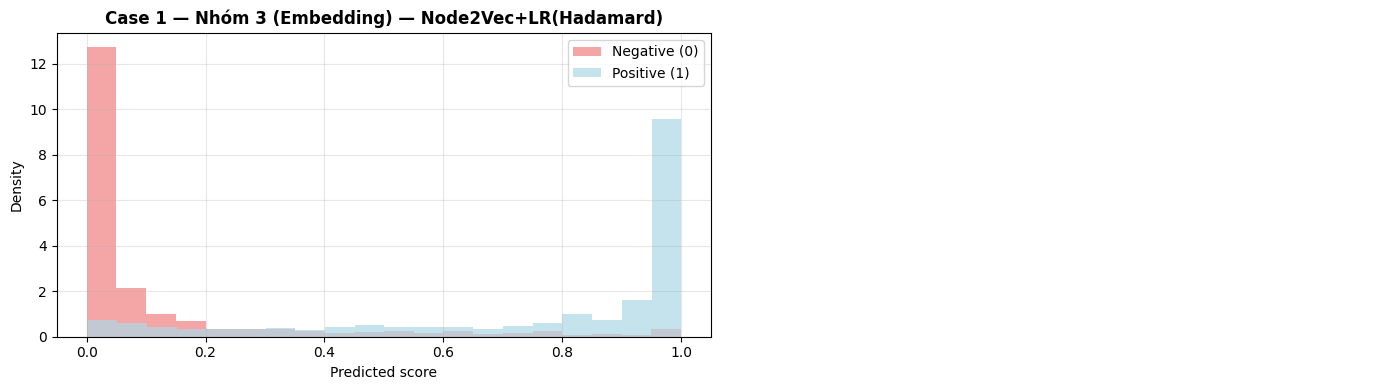

In [124]:
# ==== PHÂN PHỐI ĐIỂM — NHÓM 3 (CASE 1) ====
import numpy as np
import matplotlib.pyplot as plt

def plot_score_distribution_group3(df, title_prefix="Case 1 — Nhóm 3 (Embedding)"):
    # Với nhóm 3 thường chỉ có 1 model; nhưng viết tổng quát cho nhiều model
    models = df["model"].unique().tolist()
    n = len(models)
    ncols = 2
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten().tolist()
    else:
        axes = [axes]

    for i, m in enumerate(models):
        sub = df[df["model"] == m]
        pos = sub.loc[sub["label"] == 1, "score"]
        neg = sub.loc[sub["label"] == 0, "score"]

        ax = axes[i]
        ax.hist(neg, bins=20, alpha=0.7, density=True, color="lightcoral", label="Negative (0)")
        ax.hist(pos, bins=20, alpha=0.7, density=True, color="lightblue",  label="Positive (1)")
        ax.set_title(f"{title_prefix} — {m}", fontweight='bold')
        ax.set_xlabel("Predicted score"); ax.set_ylabel("Density")
        ax.grid(True, alpha=0.3); ax.legend()

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(); plt.show()

# Vẽ ngay:
plot_score_distribution_group3(scores_case1_group3)

## Deep learning

In [125]:
# ===== NHÓM 4: Deep Learning — 2-layer GCN + Dot-Product Scoring =====
import os, random, math, json
import numpy as np
import pandas as pd
import networkx as nx

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Kiểm tra biến từ các bước trước ---
need_vars = ["G_train", "train_edges", "test_edges"]
for v in need_vars:
    if v not in globals():
        raise RuntimeError(f"Thiếu biến {v}. Hãy chạy B2–B3 trước.")
if "test_neg" not in globals():
    if "test_negative" in globals():
        test_neg = test_negative
    else:
        raise RuntimeError("Thiếu negative test edges (test_neg).")

# pos_train/neg_train có thể đã có từ nhóm 2; nếu chưa thì tạo nhanh ở đây
if "pos_train" not in globals():
    pos_train = list(train_edges)

if "neg_train" not in globals():
    def sample_negatives(G, num_samples, seed=SEED):
        rng = random.Random(seed)
        negs, nodes = set(), list(G.nodes())
        while len(negs) < num_samples:
            u, v = rng.choice(nodes), rng.choice(nodes)
            if u == v: continue
            a, b = (u, v) if u < v else (v, u)
            if G.has_edge(a, b): continue
            if (a, b) in negs: continue
            negs.add((a, b))
        return list(negs)
    neg_train = sample_negatives(G_train, len(pos_train), seed=SEED)

# --- PyTorch setup ---
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(SEED)

# --- 1) Mapping node <-> index, adjacency chuẩn hoá ---
nodes = list(G_train.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

import scipy.sparse as sp
A = nx.to_scipy_sparse_array(G_train, nodelist=nodes, format="csr", dtype=np.float32)
A_hat = A + sp.eye(N, dtype=np.float32, format="csr")

deg = np.array(A_hat.sum(axis=1)).ravel()
deg[deg == 0] = 1.0
D_inv_sqrt = sp.diags(1.0 / np.sqrt(deg), format="csr", dtype=np.float32)
A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt

A_norm = A_norm.tocoo()
indices = torch.from_numpy(np.vstack((A_norm.row, A_norm.col)).astype(np.int64))
values = torch.from_numpy(A_norm.data)
A_norm_sp = torch.sparse_coo_tensor(indices, values, size=(N, N))

X = torch.ones((N, 1), dtype=torch.float32)

# --- 2) Build dataset ---
def edges_to_idx_pairs(edge_list):
    return torch.tensor([[node_to_idx[u], node_to_idx[v]] for (u, v) in edge_list], dtype=torch.long)

train_pos_idx = edges_to_idx_pairs(pos_train)
train_neg_idx = edges_to_idx_pairs(neg_train)
test_pos_idx  = edges_to_idx_pairs(test_edges)
test_neg_idx  = edges_to_idx_pairs(test_neg)

y_train = torch.cat([torch.ones(len(train_pos_idx)), torch.zeros(len(train_neg_idx))], dim=0)
train_pairs = torch.cat([train_pos_idx, train_neg_idx], dim=0)

y_test = torch.cat([torch.ones(len(test_pos_idx)), torch.zeros(len(test_neg_idx))], dim=0)
test_pairs = torch.cat([test_pos_idx, test_neg_idx], dim=0)

perm = torch.randperm(len(train_pairs))
train_pairs, y_train = train_pairs[perm], y_train[perm]

# --- 3) Định nghĩa GCN ---
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim, bias=bias)
    def forward(self, x, A_norm):
        x = torch.sparse.mm(A_norm, x)
        return self.lin(x)

class GCNLinkPredictor(nn.Module):
    def __init__(self, in_dim=1, h_dim=64, out_dim=64, dropout=0.0):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, h_dim)
        self.gcn2 = GCNLayer(h_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, A_norm):
        h = F.relu(self.gcn1(x, A_norm))
        h = self.dropout(h)
        return self.gcn2(h, A_norm)
    def edge_score(self, h, pairs):
        u, v = h[pairs[:,0]], h[pairs[:,1]]
        return (u * v).sum(dim=1)

# --- 4) Huấn luyện ---
device = torch.device("cpu")
X, A_norm_sp = X.to(device), A_norm_sp.coalesce().to(device)
train_pairs, y_train = train_pairs.to(device), y_train.to(device)
test_pairs, y_test = test_pairs.to(device), y_test.to(device)

model = GCNLinkPredictor(in_dim=1, h_dim=64, out_dim=64, dropout=0.1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
loss_fn = nn.BCEWithLogitsLoss()

EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    model.train()
    opt.zero_grad()
    H = model(X, A_norm_sp)
    logits = model.edge_score(H, train_pairs)
    loss = loss_fn(logits, y_train)
    loss.backward()
    opt.step()
    if epoch % 20 == 0:
        with torch.no_grad():
            model.eval()
            H_eval = model(X, A_norm_sp)
            train_prob = torch.sigmoid(model.edge_score(H_eval, train_pairs)).cpu().numpy()
            from sklearn.metrics import roc_auc_score
            tr_auc = roc_auc_score(y_train.cpu().numpy(), train_prob)
            print(f"[Epoch {epoch:03d}] loss={loss.item():.4f} | train AUC-ROC={tr_auc:.4f}")

# --- 5) Đánh giá test ---
model.eval()
with torch.no_grad():
    H = model(X, A_norm_sp)
    test_prob = torch.sigmoid(model.edge_score(H, test_pairs)).cpu().numpy()

from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, auc, roc_curve
y_test_np = y_test.cpu().numpy()

fpr, tpr, _ = roc_curve(y_test_np, test_prob)
auc_roc = roc_auc_score(y_test_np, test_prob)

prec, rec, _ = precision_recall_curve(y_test_np, test_prob)
auc_pr = auc(rec, prec)
ap = average_precision_score(y_test_np, test_prob)

model_name = "GCN(2-layer)+Dot"
print(f"[{model_name}] AUC-ROC={auc_roc:.4f} | AUC-PR={auc_pr:.4f} | AP={ap:.4f}")

# --- 6) Append vào result_1.csv ---
row = pd.DataFrame([{
    "model": model_name,
    "AUC_ROC": auc_roc,
    "AUC_PR": auc_pr,
    "Average_Precision": ap,
    "fpr": json.dumps(fpr.tolist()),
    "tpr": json.dumps(tpr.tolist()),
    "precision": json.dumps(prec.tolist()),
    "recall": json.dumps(rec.tolist())
}])

out_file = "result_1.csv"
if os.path.exists(out_file):
    row.to_csv(out_file, mode="a", header=False, index=False)
else:
    row.to_csv(out_file, index=False)

print(f"Đã append kết quả Nhóm 4 (Deep) vào {out_file}")

[Epoch 020] loss=0.6946 | train AUC-ROC=0.7434
[Epoch 040] loss=0.6621 | train AUC-ROC=0.7407
[Epoch 060] loss=0.6546 | train AUC-ROC=0.7426
[Epoch 080] loss=0.6494 | train AUC-ROC=0.7411
[Epoch 100] loss=0.6436 | train AUC-ROC=0.7418
[GCN(2-layer)+Dot] AUC-ROC=0.6867 | AUC-PR=0.7126 | AP=0.7129
Đã append kết quả Nhóm 4 (Deep) vào result_1.csv


In [126]:
# ==== LƯU PER-EDGE SCORES — NHÓM 4 (CASE 1) ====
# test_pairs hiện đang là [test_pos_idx ; test_neg_idx] theo đúng thứ tự
# test_prob là xác suất tương ứng theo đúng thứ tự trên

# Lấy lại danh sách (u,v) theo đúng thứ tự test_pairs
test_uv = [(nodes[iu.item()], nodes[iv.item()]) for iu, iv in test_pairs.cpu()]

scores_case1_group4 = pd.DataFrame({
    "u": [u for (u, v) in test_uv],
    "v": [v for (u, v) in test_uv],
    "label": np.hstack([
        np.ones(len(test_edges), dtype=int),
        np.zeros(len(test_neg), dtype=int)
    ]),
    "score": test_prob,             # xác suất sigmoid đã tính ở trên
})
scores_case1_group4["model"] = model_name   # "GCN(2-layer)+Dot"
scores_case1_group4["group"] = "GCN"
scores_case1_group4["case"]  = "case1"

scores_out = "scores_case1_group4.csv"
if os.path.exists(scores_out):
    scores_case1_group4.to_csv(scores_out, mode="a", header=False, index=False)
else:
    scores_case1_group4.to_csv(scores_out, index=False)

print(f"Đã lưu per-edge scores Nhóm 4 (Case 1) vào {scores_out}")
print(scores_case1_group4.head())

Đã lưu per-edge scores Nhóm 4 (Case 1) vào scores_case1_group4.csv
         u        v  label     score             model group   case
0  A000305  A000370      1  0.615204  GCN(2-layer)+Dot   GCN  case1
1  A000048  A000125      1  0.683393  GCN(2-layer)+Dot   GCN  case1
2  A000010  A000550      1  0.709924  GCN(2-layer)+Dot   GCN  case1
3  A000386  A000516      1  0.563158  GCN(2-layer)+Dot   GCN  case1
4  A000121  A000191      1  0.572082  GCN(2-layer)+Dot   GCN  case1


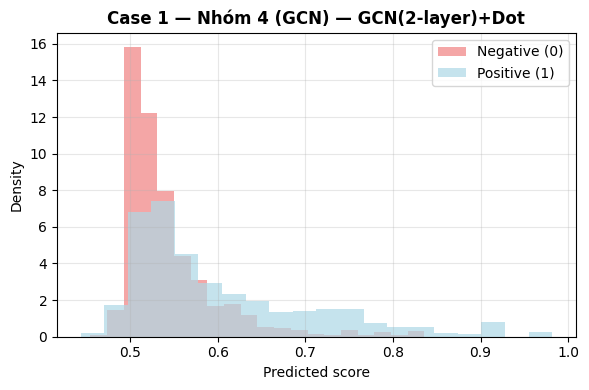

In [127]:
# ==== PHÂN PHỐI ĐIỂM — NHÓM 4 (CASE 1) ====
import numpy as np
import matplotlib.pyplot as plt

def plot_score_distribution_gcn(df, title="Case 1 — Nhóm 4 (GCN)"):
    pos = df.loc[df["label"] == 1, "score"]
    neg = df.loc[df["label"] == 0, "score"]

    plt.figure(figsize=(6, 4))
    plt.hist(neg, bins=20, alpha=0.7, density=True, color="lightcoral", label="Negative (0)")
    plt.hist(pos, bins=20, alpha=0.7, density=True, color="lightblue",  label="Positive (1)")
    plt.title(f"{title} — {df['model'].iloc[0]}", fontweight="bold")
    plt.xlabel("Predicted score"); plt.ylabel("Density")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

plot_score_distribution_gcn(scores_case1_group4)

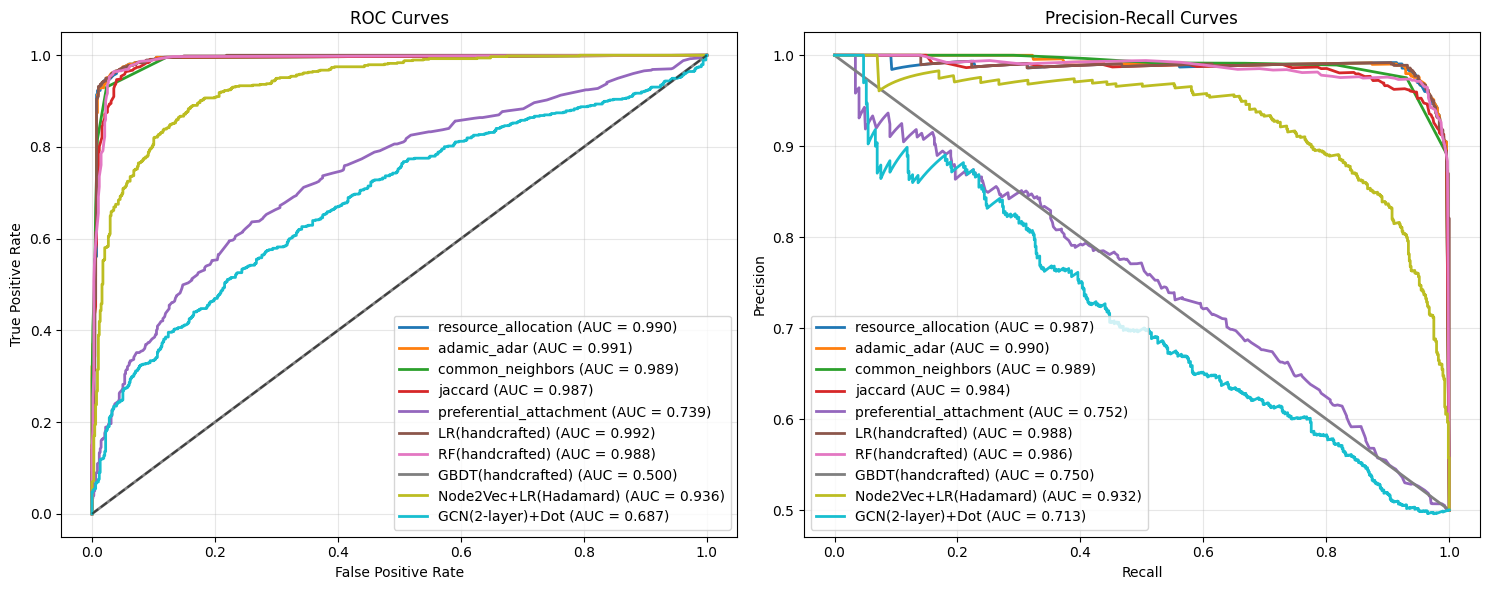

In [128]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Đọc file kết quả
df = pd.read_csv("result_1.csv")

# Parse các cột dạng string list thành list thật
for col in ["fpr", "tpr", "precision", "recall"]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Gom dữ liệu thành dict
evaluation_data = {}
for _, row in df.iterrows():
    evaluation_data[row["model"]] = {
        "auc_roc": row["AUC_ROC"],
        "auc_pr": row["AUC_PR"],
        "avg_precision": row["Average_Precision"],
        "fpr": row["fpr"],
        "tpr": row["tpr"],
        "precision": row["precision"],
        "recall": row["recall"],
    }

# Vẽ ROC và PR Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curves
ax1 = axes[0]
for name, data in evaluation_data.items():
    ax1.plot(data['fpr'], data['tpr'],
             label=f"{name} (AUC = {data['auc_roc']:.3f})", linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
ax2 = axes[1]
for name, data in evaluation_data.items():
    ax2.plot(data['recall'], data['precision'],
             label=f"{name} (AUC = {data['auc_pr']:.3f})", linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

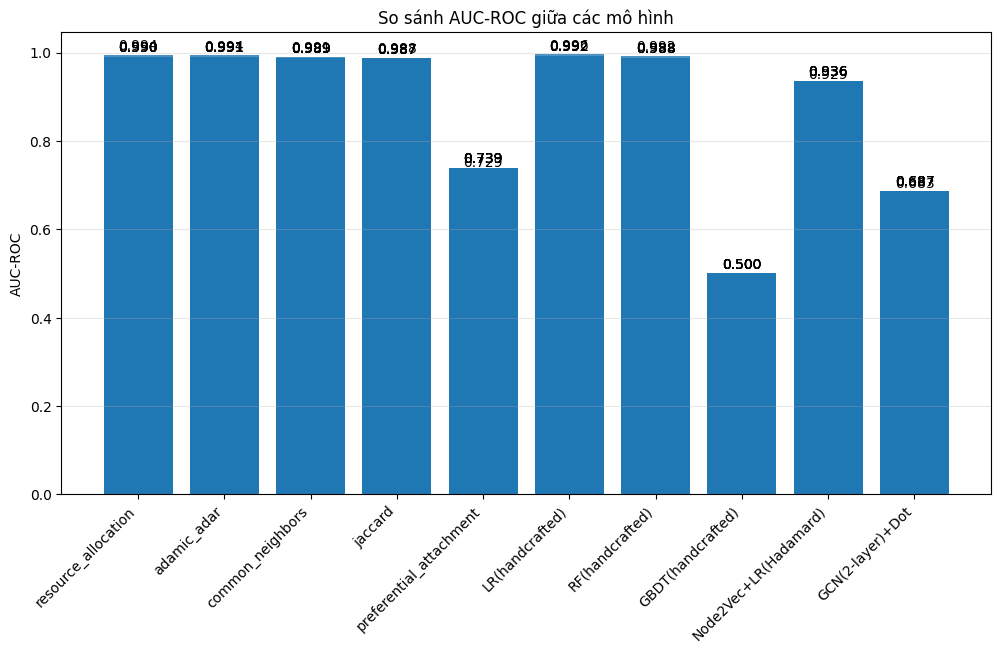

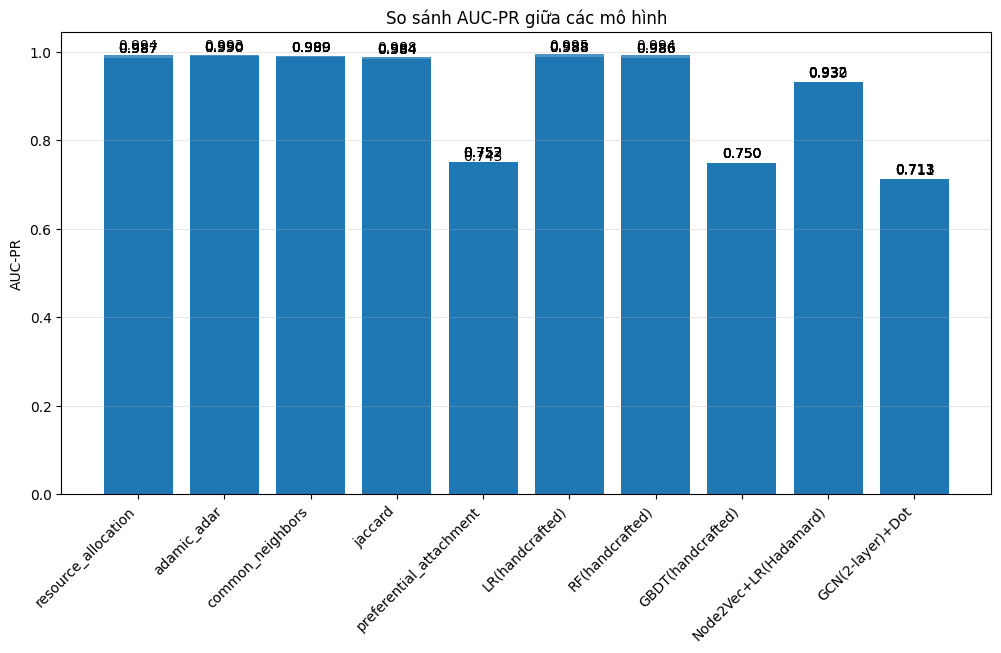

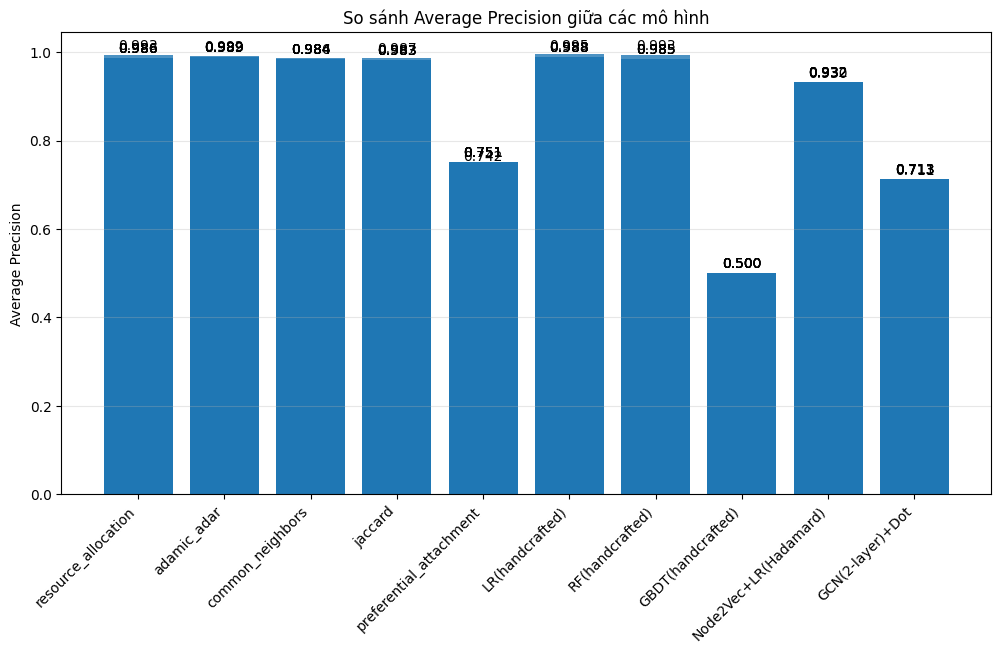

In [129]:
# ========================
# Vẽ Barplot các thang đo
# ========================

# Barplot AUC-ROC
plt.figure(figsize=(12, 6))
bars = plt.bar(df['model'], df['AUC_ROC'], alpha=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("AUC-ROC")
plt.title("So sánh AUC-ROC giữa các mô hình")
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, df['AUC_ROC']):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.005,
             f"{value:.3f}", ha='center', va='bottom')
plt.show()

# Barplot AUC-PR
plt.figure(figsize=(12, 6))
bars = plt.bar(df['model'], df['AUC_PR'], alpha=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("AUC-PR")
plt.title("So sánh AUC-PR giữa các mô hình")
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, df['AUC_PR']):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.005,
             f"{value:.3f}", ha='center', va='bottom')
plt.show()

# Barplot Average Precision
plt.figure(figsize=(12, 6))
bars = plt.bar(df['model'], df['Average_Precision'], alpha=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Precision")
plt.title("So sánh Average Precision giữa các mô hình")
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, df['Average_Precision']):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.005,
             f"{value:.3f}", ha='center', va='bottom')
plt.show()

# Cách 2:

In [130]:
# ==== SHUFFLE 80/20 + TÍNH ĐIỂM HEURISTIC (CASE 2) ====
import random
import numpy as np
import pandas as pd
import networkx as nx

# Chọn đồ thị làm việc
GRAPH_FOR_SPLIT = WORK_G if 'WORK_G' in globals() else (G if 'G' in globals() else None)
if GRAPH_FOR_SPLIT is None:
    raise RuntimeError("Chưa có G/WORK_G. Hãy chạy phần dựng đồ thị trước.")
assert not GRAPH_FOR_SPLIT.is_directed(), "Đoạn này dùng cho đồ thị vô hướng."

SEED = 42
TEST_RATIO = 0.20
random.seed(SEED)
np.random.seed(SEED)

# 1) Xáo trộn cạnh và chia 80/20
def split_edges_random(G, test_ratio=0.2, seed=42):
    rng = random.Random(seed)
    edges = list(G.edges())
    rng.shuffle(edges)
    cut = int(len(edges) * (1 - test_ratio))
    train_edges = edges[:cut]
    test_edges  = edges[cut:]
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)
    return G_train, train_edges, test_edges

G_train_c2, train_edges_c2, test_edges_c2 = split_edges_random(GRAPH_FOR_SPLIT, TEST_RATIO, SEED)

# 2) Tạo negative samples cho test (cùng số lượng)
def sample_negatives(G, num_samples, seed=42):
    rng = random.Random(seed)
    negs = set()
    nodes = list(G.nodes())
    while len(negs) < num_samples:
        u = rng.choice(nodes); v = rng.choice(nodes)
        if u == v:
            continue
        a, b = (u, v) if u < v else (v, u)
        if G.has_edge(a, b) or (a, b) in negs:
            continue
        negs.add((a, b))
    return list(negs)

test_negative_c2 = sample_negatives(G_train_c2, len(test_edges_c2), seed=SEED)

print(f"[Split] train_edges={len(train_edges_c2)}, test_edges={len(test_edges_c2)}, neg_test={len(test_negative_c2)})")

# 3) Heuristic tính điểm
class LocalSimilarityMethods:
    """
    Các phương pháp dự đoán liên kết dựa trên độ tương đồng cục bộ
    """
    def __init__(self, G):
        self.G = G

    def common_neighbors(self, u, v):
        Nu, Nv = set(self.G.neighbors(u)), set(self.G.neighbors(v))
        return len(Nu & Nv)

    def jaccard_coefficient(self, u, v):
        Nu, Nv = set(self.G.neighbors(u)), set(self.G.neighbors(v))
        inter = Nu & Nv
        uni   = Nu | Nv
        return 0.0 if len(uni) == 0 else len(inter) / len(uni)

    def adamic_adar_index(self, u, v):
        Nu, Nv = set(self.G.neighbors(u)), set(self.G.neighbors(v))
        inter = Nu & Nv
        s = 0.0
        for w in inter:
            degw = self.G.degree(w)
            if degw > 1:
                s += 1.0 / np.log(degw)
        return s

    def preferential_attachment(self, u, v):
        return self.G.degree(u) * self.G.degree(v)

    def resource_allocation_index(self, u, v):
        Nu, Nv = set(self.G.neighbors(u)), set(self.G.neighbors(v))
        inter = Nu & Nv
        s = 0.0
        for w in inter:
            degw = self.G.degree(w)
            if degw > 0:
                s += 1.0 / degw
        return s

    def calculate_all_scores(self, edge_list):
        rows = []
        for (u, v) in edge_list:
            rows.append({
                'edge': (u, v),
                'common_neighbors': self.common_neighbors(u, v),
                'jaccard': self.jaccard_coefficient(u, v),
                'adamic_adar': self.adamic_adar_index(u, v),
                'preferential_attachment': self.preferential_attachment(u, v),
                'resource_allocation': self.resource_allocation_index(u, v)
            })
        return pd.DataFrame(rows)

# 4) Tính điểm cho test pos/neg (trên G_train_c2)
similarity_calc_c2 = LocalSimilarityMethods(G_train_c2)

test_positive_scores_c2 = similarity_calc_c2.calculate_all_scores(test_edges_c2)
test_positive_scores_c2['label'] = 1  # Positive

test_negative_scores_c2 = similarity_calc_c2.calculate_all_scores(test_negative_c2)
test_negative_scores_c2['label'] = 0  # Negative

test_data_c2 = pd.concat([test_positive_scores_c2, test_negative_scores_c2], ignore_index=True)

print("Dữ liệu test Case 2 đã được chuẩn bị:")
print(f"Positive samples: {len(test_positive_scores_c2)}")
print(f"Negative samples: {len(test_negative_scores_c2)}")
print(f"Tổng số mẫu: {len(test_data_c2)}")

print("\nMột vài mẫu đầu tiên:")
print(test_data_c2.head(10))

[Split] train_edges=2708, test_edges=677, neg_test=677)
Dữ liệu test Case 2 đã được chuẩn bị:
Positive samples: 677
Negative samples: 677
Tổng số mẫu: 1354

Một vài mẫu đầu tiên:
                 edge  common_neighbors   jaccard  adamic_adar  \
0  (A000295, A000421)                 2  0.666667     1.442695   
1  (A000204, A000280)                 6  0.857143     2.848677   
2  (A000232, A000406)                 9  0.900000     3.876204   
3  (A000121, A000520)                10  0.909091     3.479460   
4  (A000304, A000402)                 8  0.615385     2.951954   
5  (A000109, A000333)                 3  0.078947     1.014744   
6  (A000113, A000288)                 5  0.555556     1.700137   
7  (A000191, A000249)                10  0.204082     3.554465   
8  (A000199, A000330)                 5  0.178571     2.186855   
9  (A000067, A000074)                 1  0.111111     0.721348   

   preferential_attachment  resource_allocation  label  
0                        6           

In [131]:
# ==== EVALUATE HEURISTICS (CASE 2) & SAVE TO result_2.csv ====
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score, auc
)

if 'test_data_c2' not in globals():
    raise RuntimeError("Thiếu 'test_data_c2'. Hãy chạy cell chuẩn bị test_data_c2 (tính điểm heuristic) trước.")

heuristic_cols = [
    "common_neighbors",
    "jaccard",
    "adamic_adar",
    "preferential_attachment",
    "resource_allocation",
]

rows = []
y_true = test_data_c2["label"].values
for col in heuristic_cols:
    if col not in test_data_c2.columns:
        print(f"[WARN] Không tìm thấy cột '{col}' trong test_data_c2. Bỏ qua.")
        continue

    y_score = test_data_c2[col].values
    mask = ~(np.isnan(y_score) | np.isinf(y_score))
    y_true_c, y_score_c = y_true[mask], y_score[mask]
    if y_true_c.size == 0:
        print(f"[WARN] Không có dữ liệu hợp lệ cho '{col}'. Bỏ qua.")
        continue

    # Tính các đường cong & chỉ số
    fpr, tpr, _ = roc_curve(y_true_c, y_score_c)
    auc_roc = roc_auc_score(y_true_c, y_score_c)

    precision, recall, _ = precision_recall_curve(y_true_c, y_score_c)
    auc_pr = auc(recall, precision)
    ap = average_precision_score(y_true_c, y_score_c)

    # Lưu cùng format như result_1.csv (nhóm 1, trường hợp 1)
    rows.append({
        "model": col,
        "AUC_ROC": auc_roc,
        "AUC_PR": auc_pr,
        "Average_Precision": ap,
        "fpr": json.dumps(fpr.tolist()),
        "tpr": json.dumps(tpr.tolist()),
        "precision": json.dumps(precision.tolist()),
        "recall": json.dumps(recall.tolist())
    })

eval_df_case2 = pd.DataFrame(rows)
print("Kết quả đánh giá heuristic (shuffle 80/20) — CASE 2:")
print(eval_df_case2.sort_values("AUC_ROC", ascending=False).round(4))

out_file = "result_2.csv"
if os.path.exists(out_file):
    eval_df_case2.to_csv(out_file, mode="a", header=False, index=False)
else:
    eval_df_case2.to_csv(out_file, index=False)

print(f"Đã ghi kết quả CASE 2 (heuristics) vào {out_file}")

Kết quả đánh giá heuristic (shuffle 80/20) — CASE 2:
                     model  AUC_ROC  AUC_PR  Average_Precision  \
4      resource_allocation   0.9924  0.9943             0.9929   
2              adamic_adar   0.9917  0.9935             0.9920   
0         common_neighbors   0.9877  0.9894             0.9834   
1                  jaccard   0.9853  0.9865             0.9848   
3  preferential_attachment   0.7273  0.7384             0.7379   

                                                 fpr  \
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0014771048744460858, 0....   

                                                 tpr  \
4  [0.0, 0.0014771048744460858, 0.002954209748892...   
2  [0.0, 0.0014771048744460858, 0.091580502215657...   
0  [0.0, 0.0014771048744460858, 0.00590841949

In [132]:
import pandas as pd
import os
import numpy as np

name_map = {
    "common_neighbors": "Common Neighbors",
    "jaccard": "Jaccard Coefficient",
    "adamic_adar": "Adamic-Adar Index",
    "preferential_attachment": "Preferential Attachment",
    "resource_allocation": "Resource Allocation Index",
}

rows_scores = []
for _, r in test_data_c2.iterrows():
    (u, v) = r["edge"]
    lab = int(r["label"])
    for key in name_map.keys():
        if key in test_data_c2.columns:
            score_val = float(r[key])
            if not (np.isnan(score_val) or np.isinf(score_val)):
                rows_scores.append({
                    "u": u,
                    "v": v,
                    "label": lab,
                    "score": score_val,
                    "model": name_map[key],  # tên hiển thị
                    "model_key": key,        # key nội bộ nếu cần lọc
                    "group": "Heuristics",
                    "case": "case2",
                })

scores_case2_group1 = pd.DataFrame(rows_scores)

scores_out = "scores_case2_group1.csv"
if os.path.exists(scores_out):
    scores_case2_group1.to_csv(scores_out, mode="a", header=False, index=False)
else:
    scores_case2_group1.to_csv(scores_out, index=False)

print(f"Đã lưu per-edge scores Nhóm 1 (Case 2) vào {scores_out}")
print(scores_case2_group1.groupby('model')["score"].describe()[["mean","std","min","max"]])

Đã lưu per-edge scores Nhóm 1 (Case 2) vào scores_case2_group1.csv
                                 mean         std  min          max
model                                                              
Adamic-Adar Index            1.072092    1.282477  0.0     6.413403
Common Neighbors             2.709010    3.411358  0.0    19.000000
Jaccard Coefficient          0.150321    0.223736  0.0     1.000000
Preferential Attachment    170.051699  230.513037  1.0  2378.000000
Resource Allocation Index    0.222663    0.265265  0.0     1.084593


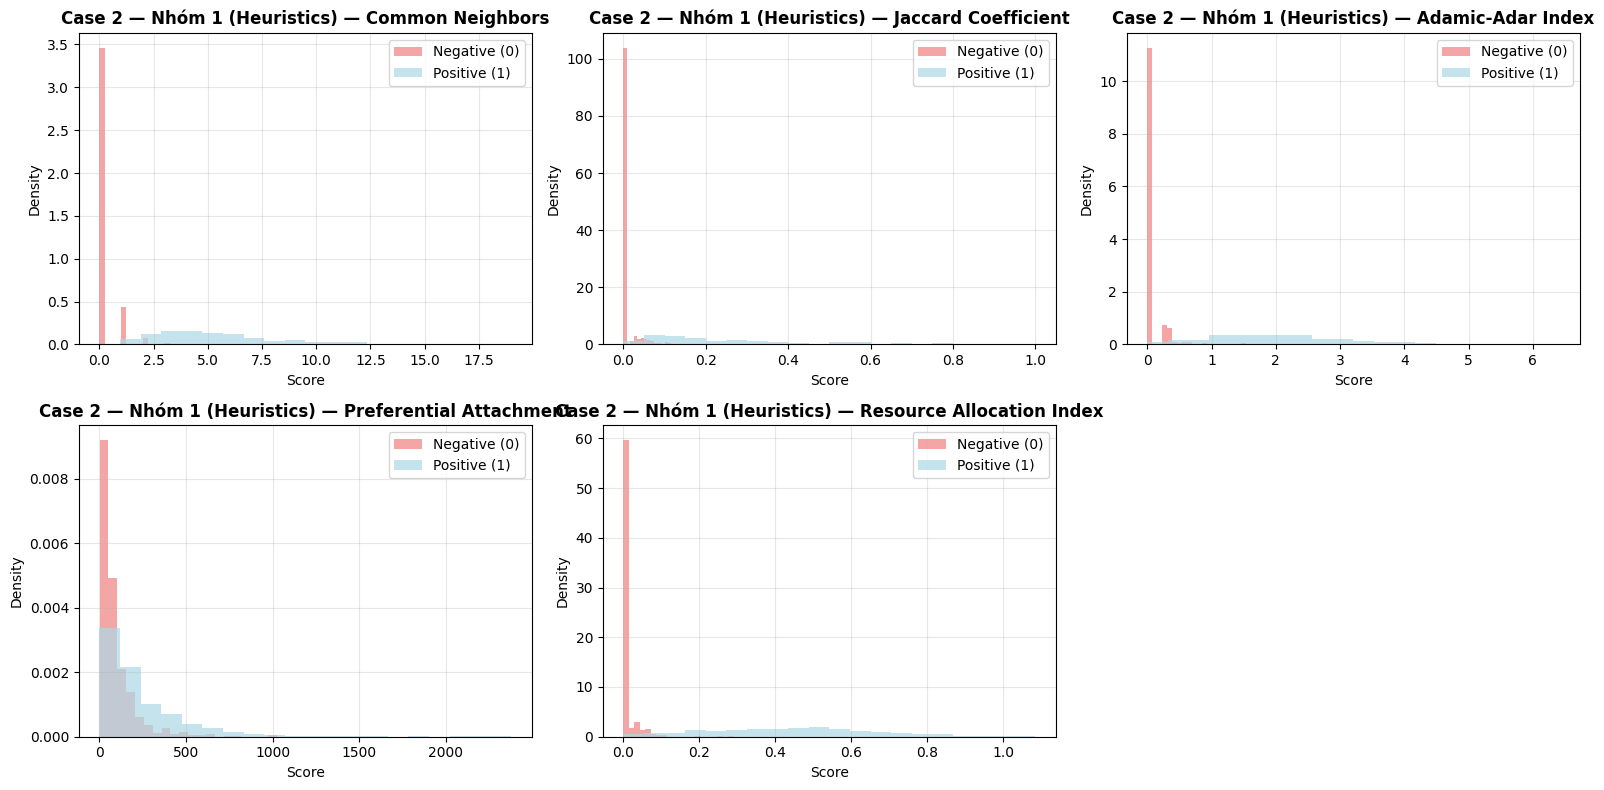

In [133]:
# ==== PHÂN PHỐI ĐIỂM — NHÓM 1 (CASE 2, Heuristics) ====
import numpy as np
import matplotlib.pyplot as plt

def plot_score_distribution_by_model(df, title_prefix="Case 2 — Nhóm 1 (Heuristics)"):
    models = df["model"].unique().tolist()
    n = len(models)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4*nrows))

    # ép axes về list Axes để không lỗi khi n==1
    if isinstance(axes, np.ndarray):
        axes = axes.flatten().tolist()
    else:
        axes = [axes]

    for i, m in enumerate(models):
        sub = df[df["model"] == m]
        pos = sub.loc[sub["label"] == 1, "score"]
        neg = sub.loc[sub["label"] == 0, "score"]

        ax = axes[i]
        ax.hist(neg, bins=20, alpha=0.7, density=True, color="lightcoral", label="Negative (0)")
        ax.hist(pos, bins=20, alpha=0.7, density=True, color="lightblue",  label="Positive (1)")
        ax.set_title(f"{title_prefix} — {m}", fontweight='bold')
        ax.set_xlabel("Score"); ax.set_ylabel("Density")
        ax.grid(True, alpha=0.3); ax.legend()

    # Ẩn subplot thừa
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(); plt.show()

# Vẽ
plot_score_distribution_by_model(scores_case2_group1)

In [134]:
import os, json, random
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

for var in ["G_train_c2", "train_edges_c2", "test_edges_c2", "test_negative_c2"]:
    if var not in globals():
        raise RuntimeError(f"Thiếu biến {var}. Hãy chạy phần shuffle 80/20 (Case 2) trước.")

SEED = 42
random.seed(SEED); np.random.seed(SEED)

def pair_features(G, u, v):
    Nu, Nv = set(G.neighbors(u)), set(G.neighbors(v))
    inter, uni = (Nu & Nv), (Nu | Nv)
    du, dv = G.degree(u), G.degree(v)
    cn = len(inter)
    jacc = 0.0 if len(uni) == 0 else len(inter) / len(uni)
    aa = sum(1.0/np.log(G.degree(w)) for w in inter if G.degree(w) > 1)
    ra = sum(1.0/G.degree(w) for w in inter if G.degree(w) > 0)
    pa = du * dv
    try:
        spl = nx.shortest_path_length(G, u, v)
    except nx.NetworkXNoPath:
        spl = 1e6
    return {
        "deg_u": du, "deg_v": dv, "deg_sum": du + dv, "deg_prod": du * dv,
        "deg_min": min(du, dv), "deg_max": max(du, dv),
        "common_neighbors": cn, "jaccard": jacc, "adamic_adar": aa,
        "resource_allocation": ra, "preferential_attachment": pa,
        "shortest_path_len": spl,
    }

def build_feature_df(G, edge_list, label):
    rows = []
    for (u, v) in edge_list:
        fv = pair_features(G, u, v); fv["u"]=u; fv["v"]=v; fv["label"]=label
        rows.append(fv)
    return pd.DataFrame(rows)

def sample_negatives(G, num_samples, seed=SEED):
    rng = random.Random(seed)
    negs, nodes = set(), list(G.nodes())
    while len(negs) < num_samples:
        u, v = rng.choice(nodes), rng.choice(nodes)
        if u == v: continue
        a, b = (u, v) if u < v else (v, u)
        if G.has_edge(a, b) or (a, b) in negs: continue
        negs.add((a, b))
    return list(negs)

pos_train_c2 = list(train_edges_c2)
neg_train_c2 = sample_negatives(G_train_c2, len(pos_train_c2), seed=SEED)

train_pos_df_c2 = build_feature_df(G_train_c2, pos_train_c2, 1)
train_neg_df_c2 = build_feature_df(G_train_c2, neg_train_c2, 0)
train_df_c2 = pd.concat([train_pos_df_c2, train_neg_df_c2], ignore_index=True)

test_pos_df_c2 = build_feature_df(G_train_c2, test_edges_c2, 1)
test_neg_df_c2 = build_feature_df(G_train_c2, test_negative_c2, 0)
test_df_ml_c2 = pd.concat([test_pos_df_c2, test_neg_df_c2], ignore_index=True)

feature_cols = [
    "deg_u","deg_v","deg_sum","deg_prod","deg_min","deg_max",
    "common_neighbors","jaccard","adamic_adar","resource_allocation",
    "preferential_attachment","shortest_path_len"
]
X_train_c2 = train_df_c2[feature_cols].values; y_train_c2 = train_df_c2["label"].values
X_test_c2  = test_df_ml_c2[feature_cols].values; y_test_c2  = test_df_ml_c2["label"].values

models_c2 = {
    "LR(handcrafted)": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF(handcrafted)": RandomForestClassifier(n_estimators=300, max_depth=None, random_state=SEED, n_jobs=-1),
    "GBDT(handcrafted)": GradientBoostingClassifier(random_state=SEED),
}

def eval_model(clf, X_tr, y_tr, X_te, y_te, name):
    clf.fit(X_tr, y_tr)
    y_score = clf.predict_proba(X_te)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_te)
    fpr, tpr, _ = roc_curve(y_te, y_score); auc_roc = roc_auc_score(y_te, y_score)
    precision, recall, _ = precision_recall_curve(y_te, y_score); auc_pr = auc(recall, precision)
    ap = average_precision_score(y_te, y_score)
    return {
        "model": name,
        "AUC_ROC": auc_roc,
        "AUC_PR": auc_pr,
        "Average_Precision": ap,
        "fpr": json.dumps(fpr.tolist()),
        "tpr": json.dumps(tpr.tolist()),
        "precision": json.dumps(precision.tolist()),
        "recall": json.dumps(recall.tolist())
    }

rows_c2 = []
for name, clf in models_c2.items():
    res = eval_model(clf, X_train_c2, y_train_c2, X_test_c2, y_test_c2, name)
    rows_c2.append(res)
    print(f"[{name}] AUC-ROC={res['AUC_ROC']:.4f} | AUC-PR={res['AUC_PR']:.4f} | AP={res['Average_Precision']:.4f}")

ml_results_df_c2 = pd.DataFrame(rows_c2)

out_file = "result_2.csv"
if os.path.exists(out_file):
    ml_results_df_c2.to_csv(out_file, mode="a", header=False, index=False)
else:
    ml_results_df_c2.to_csv(out_file, index=False)

print(f"Đã append kết quả nhóm 2 (ML, Case 2) vào {out_file}")
print(ml_results_df_c2.sort_values("AUC_ROC", ascending=False))

all_scores_rows_c2 = []
for name, clf in models_c2.items():
    clf.fit(X_train_c2, y_train_c2)
    y_score = clf.predict_proba(X_test_c2)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test_c2)
    tmp = test_df_ml_c2[["u", "v", "label"]].copy()
    tmp["score"] = y_score
    tmp["model"] = name
    tmp["case"] = "case2"
    tmp["group"] = "ML(handcrafted)"
    all_scores_rows_c2.append(tmp)

scores_case2_group2 = pd.concat(all_scores_rows_c2, ignore_index=True)
scores_case2_group2.to_csv("scores_case2_group2.csv", index=False)
print("Đã lưu per-edge scores Nhóm 2 (Case 2) vào scores_case2_group2.csv")

[LR(handcrafted)] AUC-ROC=0.9920 | AUC-PR=0.9941 | AP=0.9941
[RF(handcrafted)] AUC-ROC=0.9934 | AUC-PR=0.9960 | AP=0.9939
[GBDT(handcrafted)] AUC-ROC=0.5000 | AUC-PR=0.7500 | AP=0.5000
Đã append kết quả nhóm 2 (ML, Case 2) vào result_2.csv
               model   AUC_ROC    AUC_PR  Average_Precision  \
1    RF(handcrafted)  0.993402  0.996048           0.993859   
0    LR(handcrafted)  0.992005  0.994146           0.994147   
2  GBDT(handcrafted)  0.500000  0.750000           0.500000   

                                                 fpr  \
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2                                         [0.0, 1.0]   

                                                 tpr  \
1  [0.0, 0.0014771048744460858, 0.002954209748892...   
0  [0.0, 0.0014771048744460858, 0.053175775480059...   
2                                         [0.0, 1.0]   

                                           precision  \
1

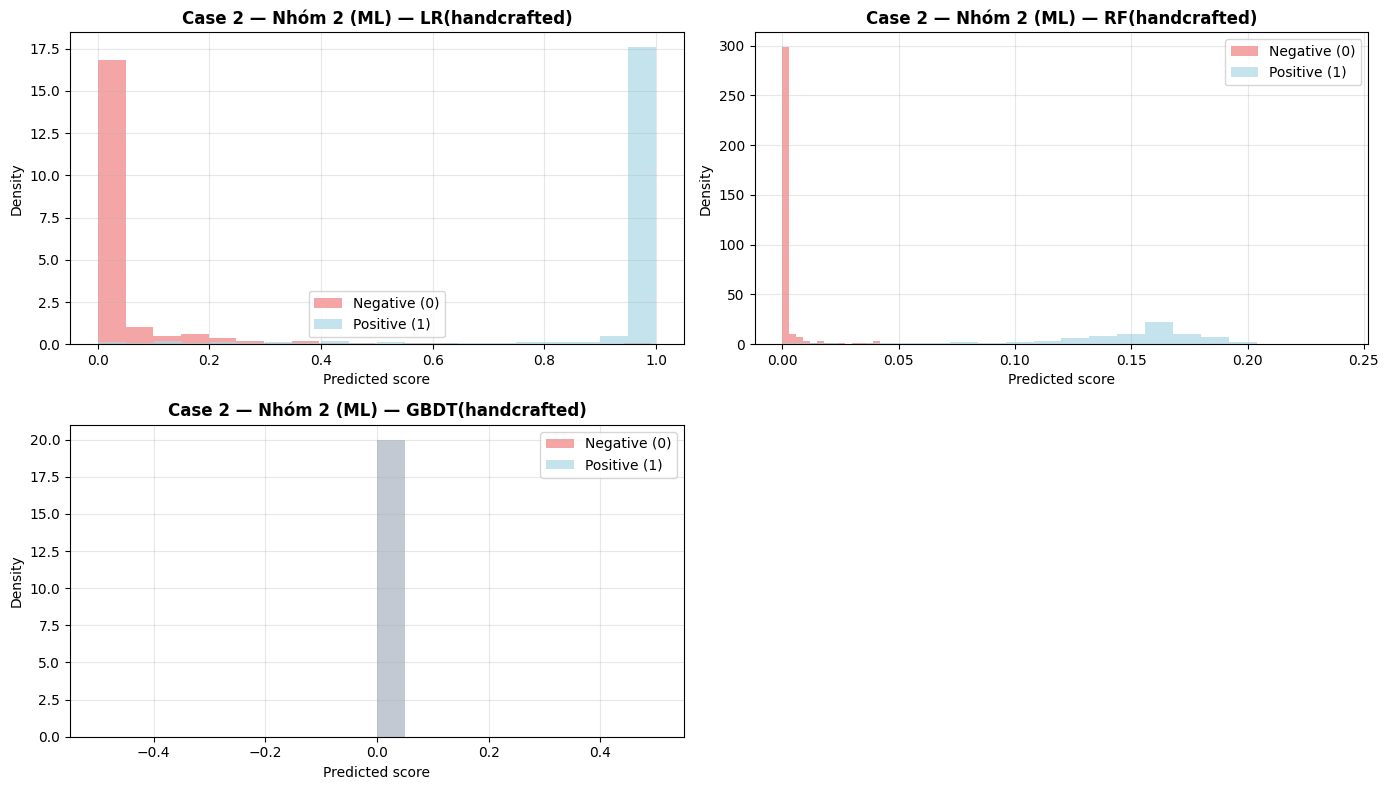

In [135]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


scores_case2_group2 = pd.read_csv("scores_case2_group2.csv")
def plot_score_distribution_by_model(df, title_prefix="Case 2 — Nhóm 2 (ML)"):
    models = df["model"].unique().tolist()
    n = len(models)
    ncols = 2
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten().tolist()
    else:
        axes = [axes]

    for i, m in enumerate(models):
        sub = df[df["model"] == m]
        pos = sub.loc[sub["label"] == 1, "score"]
        neg = sub.loc[sub["label"] == 0, "score"]

        ax = axes[i]
        ax.hist(neg, bins=20, alpha=0.7, density=True, color="lightcoral", label="Negative (0)")
        ax.hist(pos, bins=20, alpha=0.7, density=True, color="lightblue",  label="Positive (1)")
        ax.set_title(f"{title_prefix} — {m}", fontweight='bold')
        ax.set_xlabel("Predicted score"); ax.set_ylabel("Density")
        ax.grid(True, alpha=0.3); ax.legend()

    # Ẩn subplot thừa nếu có
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(); plt.show()

plot_score_distribution_by_model(scores_case2_group2)

In [136]:
# ==== NHÓM 3 (EMBEDDING) — NODE2VEC + LR (HADAMARD), SHUFFLE 80/20, APPEND result_2.csv ====
import os, json, random
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, auc

for var in ["G_train_c2", "train_edges_c2", "test_edges_c2", "test_negative_c2"]:
    if var not in globals():
        raise RuntimeError(f"Thiếu biến {var}. Hãy chạy phần shuffle 80/20 trước.")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def sample_negatives(G, num_samples, seed=SEED):
    rng = random.Random(seed)
    negs, nodes = set(), list(G.nodes())
    while len(negs) < num_samples:
        u, v = rng.choice(nodes), rng.choice(nodes)
        if u == v: continue
        a, b = (u, v) if u < v else (v, u)
        if G.has_edge(a, b) or (a, b) in negs: continue
        negs.add((a, b))
    return list(negs)

pos_train_c2 = list(train_edges_c2)
neg_train_c2 = sample_negatives(G_train_c2, len(pos_train_c2), seed=SEED)

EMBED_DIM = 128
try:
    from node2vec import Node2Vec
    n2v = Node2Vec(
        G_train_c2, dimensions=EMBED_DIM, walk_length=80, num_walks=10,
        p=1.0, q=1.0, workers=1, seed=SEED
    )
    w2v_model = n2v.fit(window=10, min_count=1, batch_words=256, seed=SEED)
    def node_vec(u):
        return w2v_model.wv[str(u)]
    embed_backend = "Node2Vec"
except Exception:
    from scipy import sparse
    from sklearn.decomposition import TruncatedSVD
    nodes = list(G_train_c2.nodes()); node_index = {n:i for i,n in enumerate(nodes)}
    A = nx.to_scipy_sparse_matrix(G_train_c2, nodelist=nodes, dtype=float, format="csr")
    deg = np.asarray(A.sum(axis=1)).ravel(); deg[deg==0]=1.0
    Dinv = sparse.diags(1.0/deg)
    P = Dinv @ A
    svd = TruncatedSVD(n_components=EMBED_DIM, random_state=SEED)
    E = svd.fit_transform(P)
    def node_vec(u):
        return E[node_index[u]]
    embed_backend = "AdjSVD"
    print("[Nhóm 3] Không tìm thấy node2vec → fallback TruncatedSVD.")

# 3) Hadamard edge features
def edge_hadamard(u, v):
    return node_vec(u) * node_vec(v)

def build_edge_matrix(edge_list):
    return np.vstack([edge_hadamard(u, v) for (u, v) in edge_list])

X_train_c2 = np.vstack([build_edge_matrix(pos_train_c2), build_edge_matrix(neg_train_c2)])
y_train_c2 = np.hstack([np.ones(len(pos_train_c2), dtype=int), np.zeros(len(neg_train_c2), dtype=int)])

X_test_c2  = np.vstack([build_edge_matrix(test_edges_c2), build_edge_matrix(test_negative_c2)])
y_test_c2  = np.hstack([np.ones(len(test_edges_c2), dtype=int), np.zeros(len(test_negative_c2), dtype=int)])

# 4) Train + Evaluate (chuẩn hóa + LR)
clf = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=2000, random_state=SEED))
])
clf.fit(X_train_c2, y_train_c2)

y_score_c2 = clf.predict_proba(X_test_c2)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test_c2)

fpr, tpr, _ = roc_curve(y_test_c2, y_score_c2)
auc_roc = roc_auc_score(y_test_c2, y_score_c2)

precision, recall, _ = precision_recall_curve(y_test_c2, y_score_c2)
auc_pr = auc(recall, precision)
ap = average_precision_score(y_test_c2, y_score_c2)

model_name = f"{embed_backend}+LR(Hadamard)"
print(f"[{model_name}] AUC-ROC={auc_roc:.4f} | AUC-PR={auc_pr:.4f} | AP={ap:.4f}")

row = pd.DataFrame([{
    "model": model_name,
    "AUC_ROC": auc_roc,
    "AUC_PR": auc_pr,
    "Average_Precision": ap,
    "fpr": json.dumps(fpr.tolist()),
    "tpr": json.dumps(tpr.tolist()),
    "precision": json.dumps(precision.tolist()),
    "recall": json.dumps(recall.tolist())
}])

out_file = "result_2.csv"
if os.path.exists(out_file):
    row.to_csv(out_file, mode="a", header=False, index=False)
else:
    row.to_csv(out_file, index=False)

print(f"Đã append kết quả nhóm 3 (Embedding) vào {out_file}")

edges_test_c2 = list(test_edges_c2) + list(test_negative_c2)

scores_df_c2 = pd.DataFrame({
    "u": [u for u, v in edges_test_c2],
    "v": [v for u, v in edges_test_c2],
    "label": y_test_c2,
    "score": y_score_c2,
    "model": model_name,
    "case": "case2",
    "group": "Embedding"
})

scores_out = "scores_case2_group3.csv"
if os.path.exists(scores_out):
    scores_df_c2.to_csv(scores_out, mode="a", header=False, index=False)
else:
    scores_df_c2.to_csv(scores_out, index=False)

print(f"Đã lưu per-edge scores Nhóm 3 (Case 2) vào {scores_out}")

Computing transition probabilities:   0%|          | 0/545 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 11.43it/s]


[Node2Vec+LR(Hadamard)] AUC-ROC=0.9463 | AUC-PR=0.9506 | AP=0.9507
Đã append kết quả nhóm 3 (Embedding) vào result_2.csv
Đã lưu per-edge scores Nhóm 3 (Case 2) vào scores_case2_group3.csv


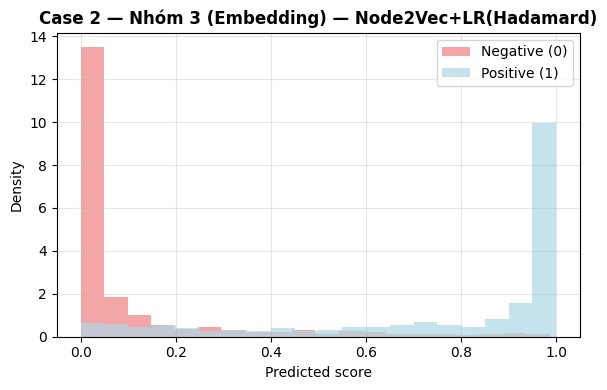

In [137]:
import matplotlib.pyplot as plt
sub = pd.read_csv("scores_case2_group3.csv")

pos = sub.loc[sub["label"] == 1, "score"]
neg = sub.loc[sub["label"] == 0, "score"]

plt.figure(figsize=(6,4))
plt.hist(neg, bins=20, alpha=0.7, density=True, color="lightcoral", label="Negative (0)")
plt.hist(pos, bins=20, alpha=0.7, density=True, color="lightblue",  label="Positive (1)")
plt.title(f"Case 2 — Nhóm 3 (Embedding) — {sub['model'].iloc[0]}", fontweight="bold")
plt.xlabel("Predicted score"); plt.ylabel("Density")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

In [138]:
# ==== NHÓM 4 (DEEP LEARNING) — GCN 2-LAYER + DOT, SHUFFLE 80/20, APPEND result_2.csv ====
import os, json
import random
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F

# Cần các biến đã có từ bước shuffle 80/20 (Case 2):
for var in ["G_train_c2", "train_edges_c2", "test_edges_c2", "test_negative_c2"]:
    if var not in globals():
        raise RuntimeError(f"Thiếu biến {var}. Hãy chạy phần shuffle 80/20 trước.")

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cpu")

# -------- 1) Chuẩn bị node index + adjacency chuẩn hoá --------
nodes = list(G_train_c2.nodes())
node_to_idx_c2 = {u: i for i, u in enumerate(nodes)}
N = len(nodes)

# A_hat = D^{-1/2} (A + I) D^{-1/2} dưới dạng sparse tensor
row, col = [], []
for (u, v) in G_train_c2.edges():
    i, j = node_to_idx_c2[u], node_to_idx_c2[v]
    row += [i, j]; col += [j, i]
# self-loop
row += list(range(N)); col += list(range(N))
vals = np.ones(len(row), dtype=np.float32)

deg = np.bincount(row, minlength=N).astype(np.float32)
deg_inv_sqrt = 1.0 / np.sqrt(np.maximum(deg, 1e-12))
norm_vals = deg_inv_sqrt[row] * vals * deg_inv_sqrt[col]

indices = torch.tensor([row, col], dtype=torch.long, device=device)
values  = torch.tensor(norm_vals, dtype=torch.float32, device=device)
A_hat_c2 = torch.sparse_coo_tensor(indices, values, size=(N, N)).coalesce()

# -------- 2) Model GCN 2-layer học embedding nút --------
class GCN(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64, out_dim=64, dropout=0.2):
        super().__init__()
        self.E = nn.Parameter(torch.randn(num_nodes, hidden_dim) * 0.01)
        self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W2 = nn.Linear(hidden_dim, out_dim, bias=False)
        self.dropout = dropout

    def forward(self, A_hat):
        H0 = self.E
        H1 = torch.sparse.mm(A_hat, H0)
        H1 = self.W1(H1)
        H1 = F.relu(H1)
        H1 = F.dropout(H1, p=self.dropout, training=self.training)
        H2 = torch.sparse.mm(A_hat, H1)
        Z  = self.W2(H2)
        return Z

model_c2 = GCN(N, hidden_dim=64, out_dim=64, dropout=0.2).to(device)
opt = torch.optim.Adam(model_c2.parameters(), lr=0.01, weight_decay=1e-4)

# -------- 3) Cặp cạnh train (pos/neg) --------
def sample_negatives(G, num_samples, seed=SEED):
    rng = random.Random(seed)
    negs = set()
    nodes_list = list(G.nodes())
    while len(negs) < num_samples:
        u, v = rng.choice(nodes_list), rng.choice(nodes_list)
        if u == v: continue
        a, b = (u, v) if u < v else (v, u)
        if G.has_edge(a, b) or (a, b) in negs: continue
        negs.add((a, b))
    return list(negs)

pos_train_c2 = list(train_edges_c2)
neg_train_c2 = sample_negatives(G_train_c2, len(pos_train_c2), seed=SEED)

pos_idx_c2 = torch.tensor([(node_to_idx_c2[u], node_to_idx_c2[v]) for (u, v) in pos_train_c2], dtype=torch.long, device=device)
neg_idx_c2 = torch.tensor([(node_to_idx_c2[u], node_to_idx_c2[v]) for (u, v) in neg_train_c2], dtype=torch.long, device=device)

BATCH = 2048
EPOCHS = 30

# -------- 4) Train loop --------
for epoch in range(1, EPOCHS+1):
    model_c2.train()
    perm_pos = torch.randperm(pos_idx_c2.size(0))
    perm_neg = torch.randperm(neg_idx_c2.size(0))
    pos_idx_epoch = pos_idx_c2[perm_pos]
    neg_idx_epoch = neg_idx_c2[perm_neg]

    total_loss = 0.0
    num_batches = int(np.ceil(pos_idx_epoch.size(0) / BATCH))
    for b in range(num_batches):
        b_start = b * BATCH
        b_end   = min((b+1) * BATCH, pos_idx_epoch.size(0))
        pos_b = pos_idx_epoch[b_start:b_end]
        neg_b = neg_idx_epoch[b_start:b_end]

        opt.zero_grad()
        Z = model_c2(A_hat_c2)

        def edge_score(pair_idx):
            u = pair_idx[:, 0]; v = pair_idx[:, 1]
            s = (Z[u] * Z[v]).sum(dim=1)
            return torch.sigmoid(s)
        s_pos = edge_score(pos_b)
        s_neg = edge_score(neg_b)

        y = torch.cat([torch.ones_like(s_pos), torch.zeros_like(s_neg)], dim=0)
        s = torch.cat([s_pos, s_neg], dim=0)

        loss = F.binary_cross_entropy(s, y)
        loss.backward()
        opt.step()
        total_loss += loss.item()

    if epoch % 5 == 0 or epoch == 1:
        print(f"[GCN Case2] Epoch {epoch}/{EPOCHS} - loss={total_loss/num_batches:.4f}")

# -------- 5) Đánh giá test --------
model_c2.eval()
with torch.no_grad():
    Z = model_c2(A_hat_c2)

def score_edges(edge_list):
    pairs = torch.tensor([(node_to_idx_c2[u], node_to_idx_c2[v]) for (u, v) in edge_list],
                         dtype=torch.long, device=device)
    u, v = pairs[:, 0], pairs[:, 1]
    s = (Z[u] * Z[v]).sum(dim=1)
    return torch.sigmoid(s).cpu().numpy()

y_score_pos_c2 = score_edges(test_edges_c2)
y_score_neg_c2 = score_edges(test_negative_c2)

y_score_c2 = np.concatenate([y_score_pos_c2, y_score_neg_c2])
y_true_c2  = np.concatenate([np.ones_like(y_score_pos_c2), np.zeros_like(y_score_neg_c2)])

fpr, tpr, _ = roc_curve(y_true_c2, y_score_c2)
auc_roc = roc_auc_score(y_true_c2, y_score_c2)
precision, recall, _ = precision_recall_curve(y_true_c2, y_score_c2)
auc_pr = auc(recall, precision)
ap = average_precision_score(y_true_c2, y_score_c2)

print(f"[GCN(2-layer)+Dot Case2] AUC-ROC={auc_roc:.4f} | AUC-PR={auc_pr:.4f} | AP={ap:.4f}")

# -------- 6) Append vào result_2.csv --------
row = pd.DataFrame([{
    "model": "GCN(2-layer)+Dot",
    "AUC_ROC": auc_roc,
    "AUC_PR": auc_pr,
    "Average_Precision": ap,
    "fpr": json.dumps(fpr.tolist()),
    "tpr": json.dumps(tpr.tolist()),
    "precision": json.dumps(precision.tolist()),
    "recall": json.dumps(recall.tolist())
}])

out_file = "result_2.csv"
if os.path.exists(out_file):
    row.to_csv(out_file, mode="a", header=False, index=False)
else:
    row.to_csv(out_file, index=False)

print(f"Đã append kết quả nhóm 4 (GCN, Case2) vào {out_file}")

# -------- 7) Lưu per-edge scores --------
edges_test_c2 = list(test_edges_c2) + list(test_negative_c2)
scores_df_c2 = pd.DataFrame({
    "u": [u for u, v in edges_test_c2],
    "v": [v for u, v in edges_test_c2],
    "label": y_true_c2,
    "score": y_score_c2,
    "model": "GCN(2-layer)+Dot",
    "case": "case2",
    "group": "GCN"
})

scores_out = "scores_case2_group4.csv"
if os.path.exists(scores_out):
    scores_df_c2.to_csv(scores_out, mode="a", header=False, index=False)
else:
    scores_df_c2.to_csv(scores_out, index=False)
print(f"Đã lưu per-edge scores Nhóm 4 (GCN, Case2) vào {scores_out}")

[GCN Case2] Epoch 1/30 - loss=0.6931
[GCN Case2] Epoch 5/30 - loss=0.6931
[GCN Case2] Epoch 10/30 - loss=0.6931
[GCN Case2] Epoch 15/30 - loss=0.6931
[GCN Case2] Epoch 20/30 - loss=0.6931
[GCN Case2] Epoch 25/30 - loss=0.6931
[GCN Case2] Epoch 30/30 - loss=0.6931
[GCN(2-layer)+Dot Case2] AUC-ROC=0.5000 | AUC-PR=0.7500 | AP=0.5000
Đã append kết quả nhóm 4 (GCN, Case2) vào result_2.csv
Đã lưu per-edge scores Nhóm 4 (GCN, Case2) vào scores_case2_group4.csv


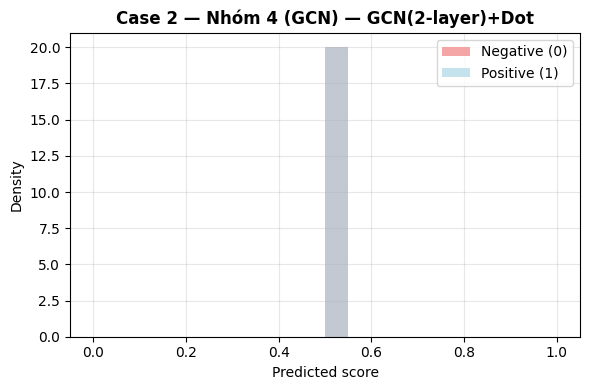

In [139]:
# ==== PHÂN PHỐI ĐIỂM — NHÓM 4 (CASE 2, GCN) ====
import pandas as pd
import matplotlib.pyplot as plt

# Nếu đã có sẵn scores_df_c2 trong bộ nhớ thì dùng, 
# còn không thì đọc lại từ file

sub = pd.read_csv("scores_case2_group4.csv")

pos = sub[sub["label"] == 1]["score"]
neg = sub[sub["label"] == 0]["score"]

plt.figure(figsize=(6, 4))
plt.hist(neg, bins=20, alpha=0.7, density=True, color="lightcoral", label="Negative (0)")
plt.hist(pos, bins=20, alpha=0.7, density=True, color="lightblue",  label="Positive (1)")
plt.title(f"Case 2 — Nhóm 4 (GCN) — {sub['model'].iloc[0]}", fontweight="bold")
plt.xlabel("Predicted score")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

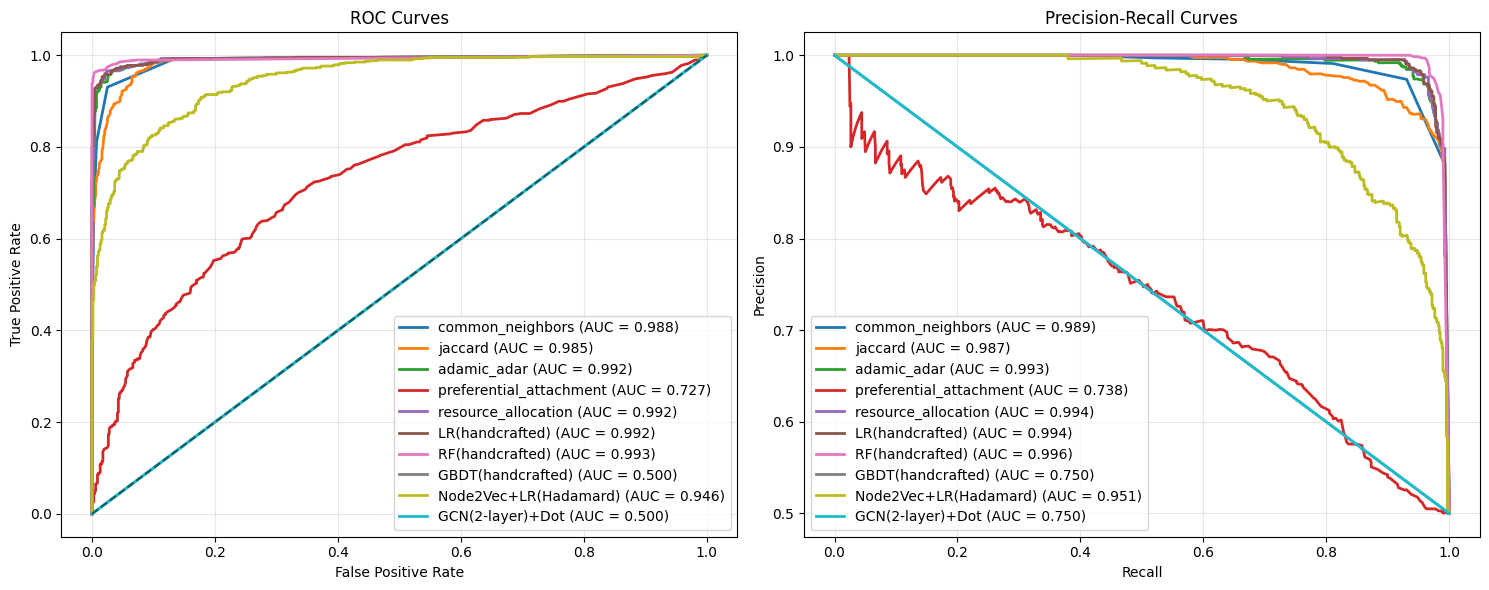

In [140]:
# ==== TRỰC QUAN CASE 2: ROC/PR CURVES ====
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Đọc file kết quả Case 2
df2 = pd.read_csv("result_2.csv")

# Parse các cột list-string thành list Python
for col in ["fpr", "tpr", "precision", "recall"]:
    if col in df2.columns:
        df2[col] = df2[col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

# Gom dữ liệu thành dict
evaluation_data_2 = {}
for _, row in df2.iterrows():
    name = row.get("model", row.get("Method", "Unknown"))
    evaluation_data_2[name] = {
        "auc_roc": row["AUC_ROC"],
        "auc_pr": row["AUC_PR"],
        "avg_precision": row["Average_Precision"],
        "fpr": row.get("fpr", None),
        "tpr": row.get("tpr", None),
        "precision": row.get("precision", None),
        "recall": row.get("recall", None),
    }

# Vẽ ROC và PR curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- ROC ---
ax1 = axes[0]
for name, data in evaluation_data_2.items():
    if data["fpr"] is not None and data["tpr"] is not None:
        ax1.plot(
            data["fpr"], data["tpr"],
            label=f"{name} (AUC = {data['auc_roc']:.3f})", linewidth=2
        )
ax1.plot([0, 1], [0, 1], "k--", alpha=0.5)
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("ROC Curves")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- PR ---
ax2 = axes[1]
for name, data in evaluation_data_2.items():
    if data["precision"] is not None and data["recall"] is not None:
        ax2.plot(
            data["recall"], data["precision"],
            label=f"{name} (AUC = {data['auc_pr']:.3f})", linewidth=2
        )
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision-Recall Curves")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

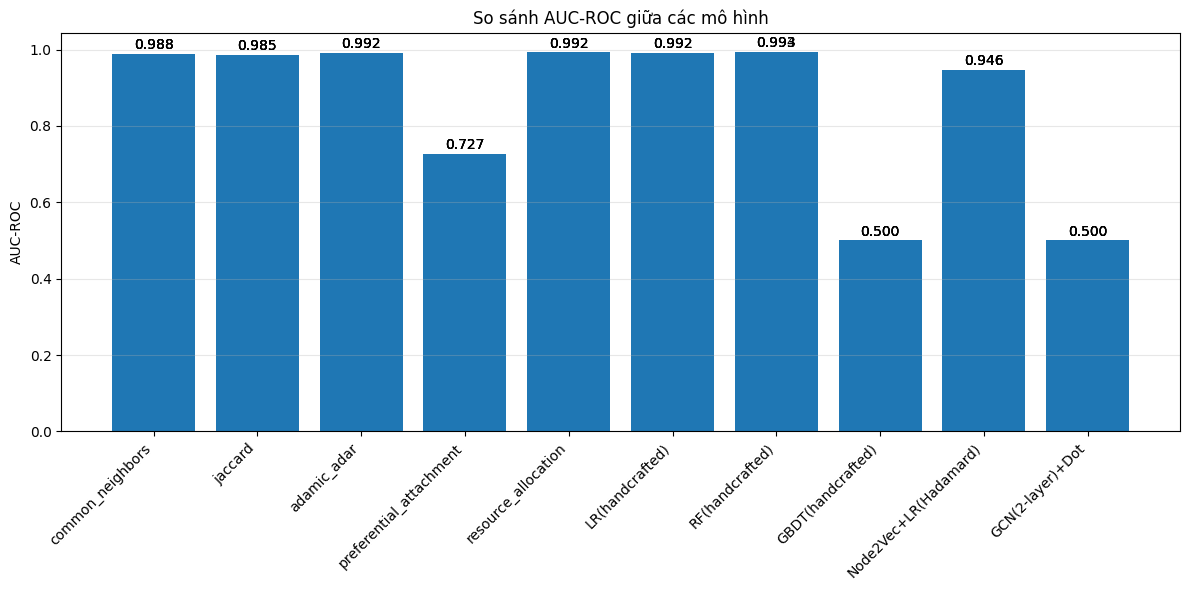

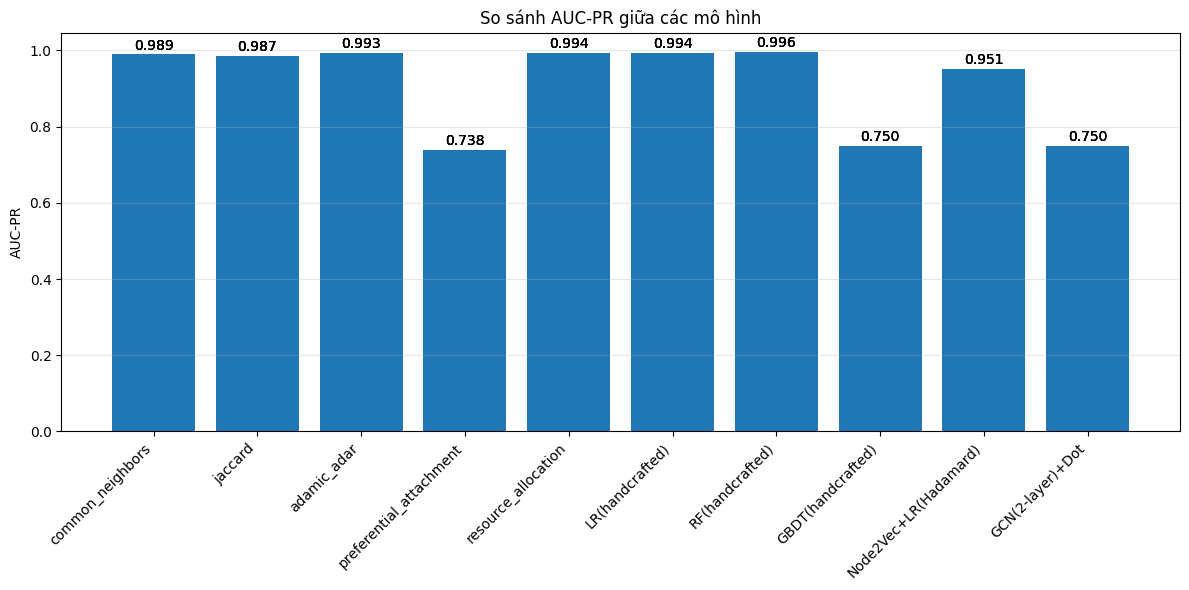

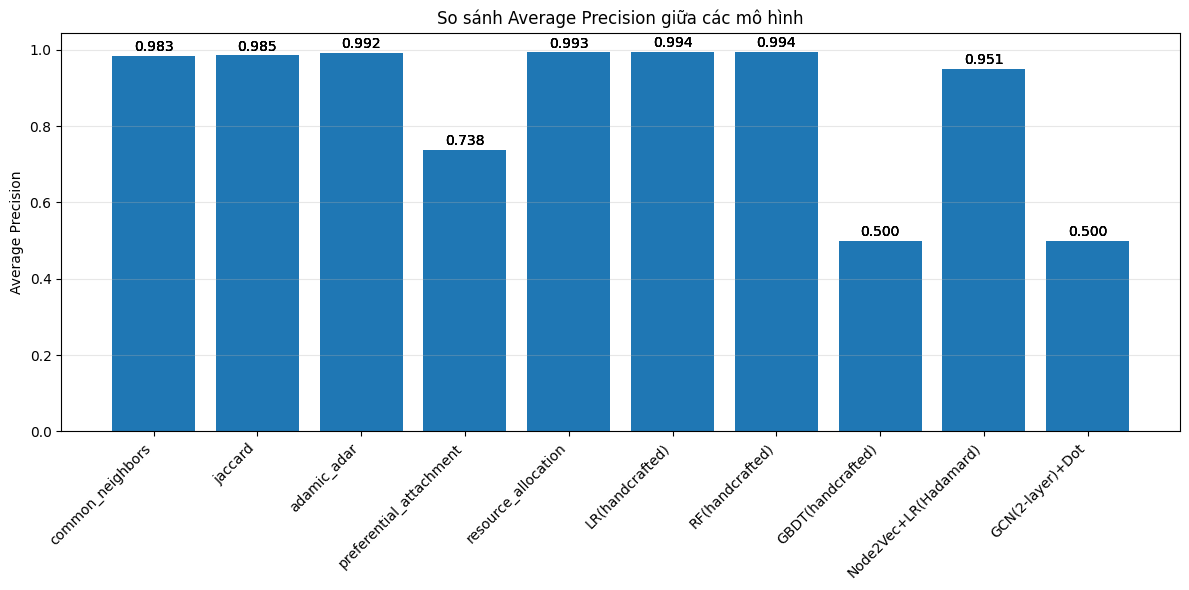

In [141]:
# ==== TRỰC QUAN CASE 2: BARPLOT AUC (AUC-ROC, AUC-PR, Average Precision) ====
import pandas as pd
import matplotlib.pyplot as plt

# Đọc kết quả Case 2
df2 = pd.read_csv("result_2.csv")

# --- Barplot AUC-ROC ---
plt.figure(figsize=(12, 6))
bars = plt.bar(df2['model'], df2['AUC_ROC'], alpha=0.85)
plt.xticks(rotation=45, ha='right')
plt.ylabel("AUC-ROC")
plt.title("So sánh AUC-ROC giữa các mô hình")
plt.grid(axis='y', alpha=0.3)
for bar, value in zip(bars, df2['AUC_ROC']):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.005,
             f"{value:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# --- Barplot AUC-PR ---
plt.figure(figsize=(12, 6))
bars = plt.bar(df2['model'], df2['AUC_PR'], alpha=0.85)
plt.xticks(rotation=45, ha='right')
plt.ylabel("AUC-PR")
plt.title("So sánh AUC-PR giữa các mô hình")
plt.grid(axis='y', alpha=0.3)
for bar, value in zip(bars, df2['AUC_PR']):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.005,
             f"{value:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# --- Barplot Average Precision ---
plt.figure(figsize=(12, 6))
bars = plt.bar(df2['model'], df2['Average_Precision'], alpha=0.85)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Precision")
plt.title("So sánh Average Precision giữa các mô hình")
plt.grid(axis='y', alpha=0.3)
for bar, value in zip(bars, df2['Average_Precision']):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.005,
             f"{value:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [142]:
import pandas as pd

df1 = pd.read_csv("result_1.csv")
df2 = pd.read_csv("result_2.csv")

df1["case"] = "case1"
df2["case"] = "case2"

# Ghép lại
df_all = pd.concat([df1, df2], ignore_index=True)

best_row = df_all.sort_values(["AUC_ROC", "Average_Precision"], ascending=False).iloc[0]

best_model = best_row["model"]
best_case  = best_row["case"]

print("Best overall model:", best_model)
print("Xuất hiện trong:", best_case)
print("AUC-ROC:", best_row["AUC_ROC"])
print("AUC-PR:", best_row["AUC_PR"])
print("Average Precision:", best_row["Average_Precision"])

Best overall model: LR(handcrafted)
Xuất hiện trong: case1
AUC-ROC: 0.9957017775440786
AUC-PR: 0.9945740532310056
Average Precision: 0.9945811422336136


In [151]:
def analyze_best_model(G_case1=None, G_case2=None, show_labels=True, label_font_size=8, top_k=5):
    """
    - Tự tìm model tốt nhất từ result_1.csv + result_2.csv
    - Load đúng scores file theo case + nhóm
    - Dùng đúng G (case1 -> G_train / G_case1; case2 -> G_train_c2 / G_case2 / fallback G_train)
    - In & vẽ các trường hợp đặc biệt (FP/FN)
    - label_font_size: cỡ chữ nhãn (mặc định 8, nhỏ gọn); có thể tắt nhãn bằng show_labels=False
    """
    # ---------- 0) Đọc kết quả & chọn best overall ----------
    if not (os.path.exists("result_1.csv") and os.path.exists("result_2.csv")):
        raise FileNotFoundError("Thiếu result_1.csv hoặc result_2.csv.")

    df1 = pd.read_csv("result_1.csv"); df1["case"] = "case1"
    df2 = pd.read_csv("result_2.csv"); df2["case"] = "case2"
    df_all = pd.concat([df1, df2], ignore_index=True)

    # Chọn best theo AUC_ROC, tie-break Average_Precision
    best_row = df_all.sort_values(["AUC_ROC", "Average_Precision"], ascending=False).iloc[0]
    best_model = best_row["model"]
    best_case  = best_row["case"]

    print("=== Best overall (across both cases) ===")
    print(f"Model: {best_model}")
    print(f"Case:  {best_case}")
    print(f"AUC-ROC={best_row['AUC_ROC']:.6f} | AUC-PR={best_row['AUC_PR']:.6f} | AP={best_row['Average_Precision']:.6f}")

    # ---------- 1) Map tới đúng scores file ----------
    heur_name_map = {
        "common_neighbors": "Common Neighbors",
        "jaccard": "Jaccard Coefficient",
        "adamic_adar": "Adamic-Adar Index",
        "preferential_attachment": "Preferential Attachment",
        "resource_allocation": "Resource Allocation Index",
    }

    if best_case == "case1":
        if best_model in heur_name_map or best_model in heur_name_map.values():
            scores_path = "scores_case1_group1.csv"
        elif "handcrafted" in best_model:
            scores_path = "scores_case1_group2.csv"
        elif "Embedding" in best_model or "Node2Vec" in best_model or "AdjSVD" in best_model:
            scores_path = "scores_case1_group3.csv"
        elif "GCN" in best_model:
            scores_path = "scores_case1_group4.csv"
        else:
            raise ValueError(f"Không nhận diện được nhóm cho model '{best_model}' (case1)")

        if G_case1 is not None:
            G_work = G_case1
        elif "G_train" in globals():
            G_work = globals()["G_train"]
        else:
            raise RuntimeError("Không tìm thấy G_train cho case1. Truyền G_case1=... vào hàm.")

    elif best_case == "case2":
        if best_model in heur_name_map or best_model in heur_name_map.values():
            scores_path = "scores_case2_group1.csv"
        elif "handcrafted" in best_model:
            scores_path = "scores_case2_group2.csv"
        elif "Embedding" in best_model or "Node2Vec" in best_model or "AdjSVD" in best_model:
            scores_path = "scores_case2_group3.csv"
        elif "GCN" in best_model:
            scores_path = "scores_case2_group4.csv"
        else:
            raise ValueError(f"Không nhận diện được nhóm cho model '{best_model}' (case2)")

        if G_case2 is not None:
            G_work = G_case2
        elif "G_train_c2" in globals():
            G_work = globals()["G_train_c2"]
        elif "G_train" in globals():
            G_work = globals()["G_train"]
            print("[WARN] Không có G_train_c2, fallback dùng G_train (có thể lệch so với case2).")
        else:
            raise RuntimeError("Không tìm thấy G_train_c2/G_train cho case2. Truyền G_case2=... vào hàm.")
    else:
        raise ValueError("case không hợp lệ.")

    if not os.path.exists(scores_path):
        raise FileNotFoundError(f"Không tìm thấy file scores: {scores_path}")

    scores_df = pd.read_csv(scores_path)

    # ---------- 2) Lọc đúng model name trong scores_df ----------
    target_names = {best_model}
    if best_model in heur_name_map:
        target_names.add(heur_name_map[best_model])

    sub_df = scores_df[scores_df["model"].isin(target_names)]
    if sub_df.empty:
        sub_df = scores_df[scores_df["model"].astype(str).str.contains(str(best_model), regex=False)]
    if sub_df.empty:
        raise RuntimeError(f"Không tìm thấy bản ghi cho model '{best_model}' trong {scores_path}")

    # ---------- 3) Tìm các trường hợp đặc biệt ----------
    def find_interesting_cases(df, G):
        print("\nPHÂN TÍCH CÁC TRƯỜNG HỢP ĐẶC BIỆT")
        print("="*50)

        # False Positives: label=0 nhưng score cao
        print("\n1) Top các cặp có score cao (False Positive, label=0):")
        top_negative = df[df["label"] == 0].nlargest(top_k, "score")
        for _, row in top_negative.iterrows():
            u, v = row["u"], row["v"]
            print(f"   ({u}, {v}): score={row['score']:.4f}")
            print(f"   - N({u}) = {list(G.neighbors(u))}")
            print(f"   - N({v}) = {list(G.neighbors(v))}")
            print()

        # False Negatives: label=1 nhưng score thấp
        print("2) Top các cặp có score thấp (False Negative, label=1):")
        low_positive = df[df["label"] == 1].nsmallest(top_k, "score")
        for _, row in low_positive.iterrows():
            u, v = row["u"], row["v"]
            print(f"   ({u}, {v}): score={row['score']:.4f}")
            print(f"   - N({u}) = {list(G.neighbors(u))}")
            print(f"   - N({v}) = {list(G.neighbors(v))}")
            print()

        return top_negative, low_positive

    def visualize_special_cases(cases, title_suffix, G, show_labels=True, label_font_size=8):
        if cases.empty:
            print(f"(Không có dữ liệu cho {title_suffix})")
            return
        k = min(3, len(cases))
        fig, axes = plt.subplots(1, k, figsize=(5*k, 5))
        if k == 1:
            axes = [axes]

        for i, (_, case) in enumerate(cases.head(k).iterrows()):
            u, v = case["u"], case["v"]
            ax = axes[i]

            # subgraph gồm u, v và láng giềng của chúng
            nodes = set([u, v])
            nodes.update(G.neighbors(u))
            nodes.update(G.neighbors(v))
            subG = G.subgraph(nodes).copy()
            pos = nx.spring_layout(subG, seed=42)

            nx.draw_networkx_edges(subG, pos, ax=ax, alpha=0.5)
            others = [n for n in subG.nodes() if n not in [u, v]]
            nx.draw_networkx_nodes(subG, pos, nodelist=others, node_color="lightgray", ax=ax)
            nx.draw_networkx_nodes(subG, pos, nodelist=[u], node_color="red", ax=ax, node_size=300)
            nx.draw_networkx_nodes(subG, pos, nodelist=[v], node_color="blue", ax=ax, node_size=300)

            if show_labels:
                nx.draw_networkx_labels(subG, pos, ax=ax, font_size=label_font_size)

            # Nếu cạnh (u,v) chưa có, vẽ đường đứt đoạn để nhấn mạnh "predicted"
            if not G.has_edge(u, v):
                ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]],
                        'r--', linewidth=2, alpha=0.85, label='Predicted edge')

            ax.set_title(f"({u}, {v}) • score={case['score']:.3f}")
            ax.axis("off")

        # Chỉ giữ đúng title_suffix
        plt.suptitle(title_suffix, fontweight="bold")
        plt.tight_layout()
        plt.show()

    # ---------- 4) Chạy ----------
    fp_df, fn_df = find_interesting_cases(sub_df, G_work)

    if len(fp_df) > 0:
        visualize_special_cases(
            fp_df,
            "Các trường hợp điểm cao (False Positives)",
            G_work,
            show_labels=show_labels,
            label_font_size=label_font_size
        )
    if len(fn_df) > 0:
        visualize_special_cases(
            fn_df,
            "Các trường hợp điểm thấp (False Negatives)",
            G_work,
            show_labels=show_labels,
            label_font_size=label_font_size
        )

    # ---------- 5) Trả về ----------
    return {
        "best_model": best_model,
        "best_case": best_case,
        "scores_file": scores_path,
        "graph_used": "G_case1/G_train" if best_case=="case1" else "G_case2/G_train_c2",
        "false_positives": fp_df,
        "false_negatives": fn_df
    }

=== Best overall (across both cases) ===
Model: LR(handcrafted)
Case:  case1
AUC-ROC=0.995702 | AUC-PR=0.994574 | AP=0.994581

PHÂN TÍCH CÁC TRƯỜNG HỢP ĐẶC BIỆT

1) Top các cặp có score cao (False Positive, label=0):
   (A000393, A000327): score=0.8153
   - N(A000393) = ['A000044', 'A000056', 'A000072', 'A000150', 'A000181', 'A000219', 'A000296', 'A000306', 'A000493']
   - N(A000327) = ['A000072', 'A000181', 'A000219']

   (A000393, A000327): score=0.8153
   - N(A000393) = ['A000044', 'A000056', 'A000072', 'A000150', 'A000181', 'A000219', 'A000296', 'A000306', 'A000493']
   - N(A000327) = ['A000072', 'A000181', 'A000219']

   (A000393, A000327): score=0.8153
   - N(A000393) = ['A000044', 'A000056', 'A000072', 'A000150', 'A000181', 'A000219', 'A000296', 'A000306', 'A000493']
   - N(A000327) = ['A000072', 'A000181', 'A000219']

   (A000393, A000327): score=0.8153
   - N(A000393) = ['A000044', 'A000056', 'A000072', 'A000150', 'A000181', 'A000219', 'A000296', 'A000306', 'A000493']
   - N(A

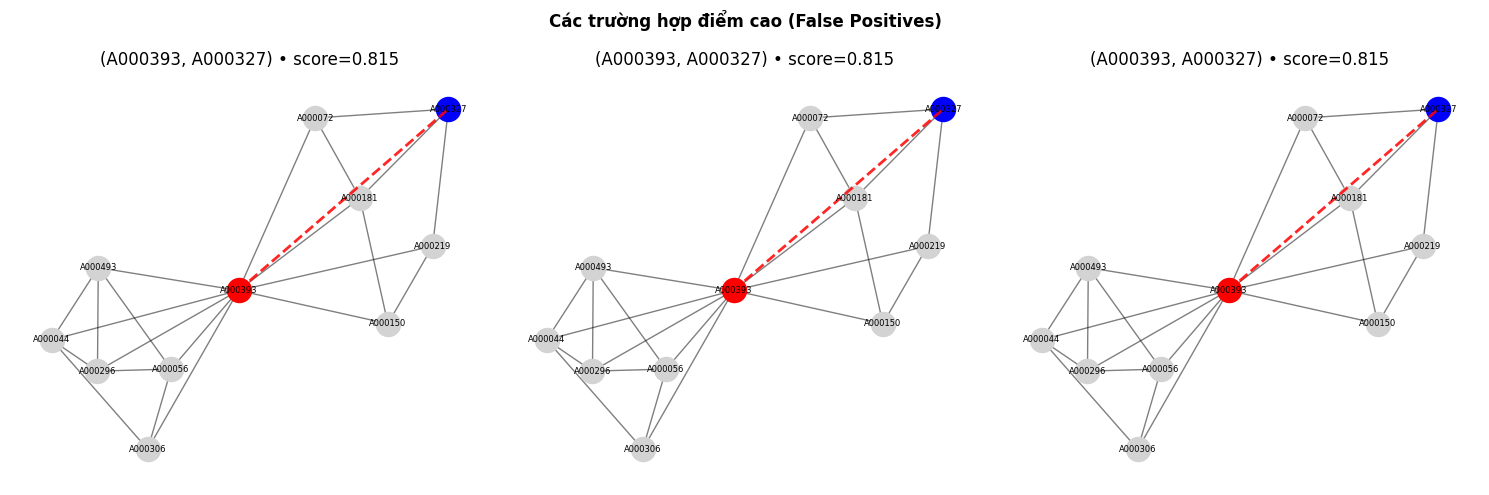

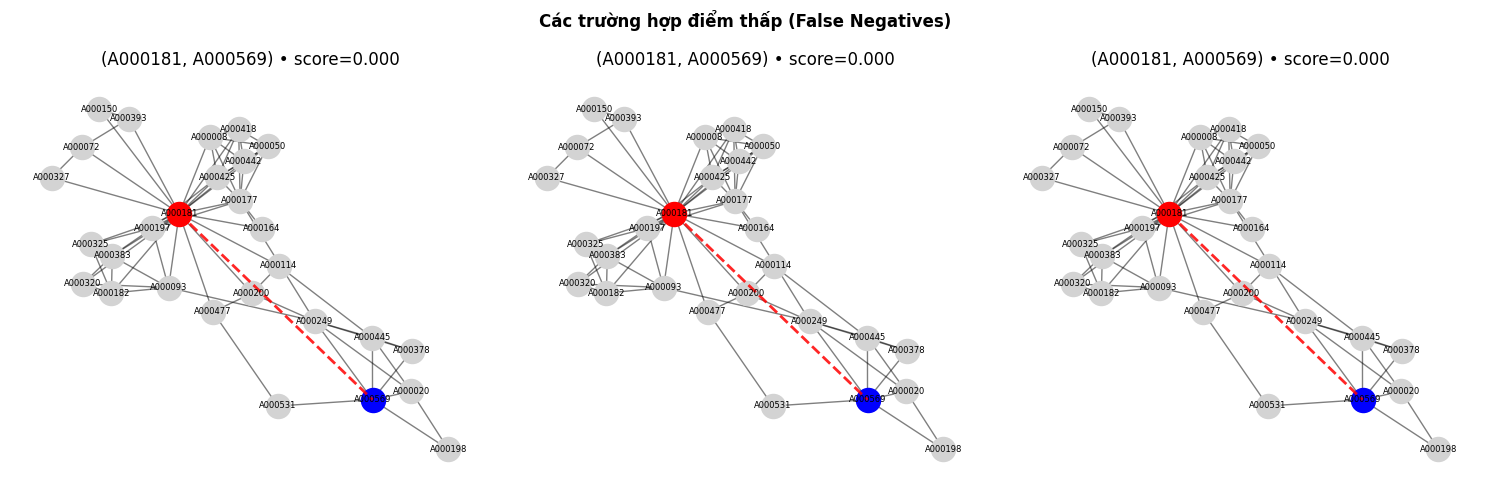

{'best_model': 'LR(handcrafted)',
 'best_case': 'case1',
 'scores_file': 'scores_case1_group2.csv',
 'graph_used': 'G_case1/G_train',
 'false_positives':              u        v  label     score            model            group  \
 5257   A000393  A000327      0  0.815257  LR(handcrafted)  ML(handcrafted)   
 9319   A000393  A000327      0  0.815257  LR(handcrafted)  ML(handcrafted)   
 13381  A000393  A000327      0  0.815257  LR(handcrafted)  ML(handcrafted)   
 17443  A000393  A000327      0  0.815257  LR(handcrafted)  ML(handcrafted)   
 21505  A000393  A000327      0  0.815257  LR(handcrafted)  ML(handcrafted)   
 
         case  
 5257   case1  
 9319   case1  
 13381  case1  
 17443  case1  
 21505  case1  ,
 'false_negatives':              u        v  label     score            model            group  \
 229    A000181  A000569      1  0.000023  LR(handcrafted)  ML(handcrafted)   
 4291   A000181  A000569      1  0.000023  LR(handcrafted)  ML(handcrafted)   
 8353   A000181  A

In [152]:
analyze_best_model(show_labels=True, label_font_size=6)
# hoặc tắt nhãn:
# analyze_best_model(show_labels=False)

In [153]:
import pandas as pd

# Đọc 2 file kết quả
df1 = pd.read_csv("result_1.csv")
df1["case"] = "case1"

df2 = pd.read_csv("result_2.csv")
df2["case"] = "case2"

# Gộp chung
df_all = pd.concat([df1, df2], ignore_index=True)

# Chỉ giữ các cột cần thiết
report = df_all[["case", "model", "AUC_ROC", "AUC_PR", "Average_Precision"]]

# Sắp xếp cho đẹp (theo case trước, rồi theo AUC_PR giảm dần)
report = report.sort_values(["case", "AUC_PR"], ascending=[True, False])

print("=== BẢNG BÁO CÁO KẾT QUẢ ===")
print(report.to_string(index=False))

=== BẢNG BÁO CÁO KẾT QUẢ ===
 case                   model  AUC_ROC   AUC_PR  Average_Precision
case1         LR(handcrafted) 0.995702 0.994574           0.994581
case1         RF(handcrafted) 0.992482 0.994312           0.992631
case1     resource_allocation 0.993919 0.993551           0.992624
case1             adamic_adar 0.993711 0.993029           0.992104
case1        common_neighbors 0.990544 0.990205           0.985506
case1             adamic_adar 0.990868 0.990147           0.989197
case1             adamic_adar 0.990868 0.990147           0.989197
case1             adamic_adar 0.990868 0.990147           0.989197
case1             adamic_adar 0.990868 0.990147           0.989197
case1             adamic_adar 0.990868 0.990147           0.989197
case1             adamic_adar 0.990868 0.990147           0.989197
case1        common_neighbors 0.988690 0.988710           0.983666
case1        common_neighbors 0.988690 0.988710           0.983666
case1        common_neighbors 0.9